In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1ltWwqlwJKEmzaSm-OnYH5gHewij0D57v

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1ltWwqlwJKEmzaSm-OnYH5gHewij0D57v
To: /content/data.csv
100% 307k/307k [00:00<00:00, 4.81MB/s]


In [ ]:
!pip install imblearn
!pip install scikit-learn==0.23
!pip install category_encoders
!pip install umap-learn
!pip install six

     |████████████████████████████████| 7.3 MB 26.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 29.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=f490870c1efb22223ceeb9514145189cded4909b7fe3425d601841895bfc63de
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=f11385144a02637a10be7e073abeab169dd6072dff19e4a06636d1bb4d52d7af
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


 # Dependencies

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from itertools import cycle
from scipy import interp


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, recall_score, f1_score


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import six
import sys
sys.modules['sklearn.externals.six'] = six
"""import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils'] = sklearn.utils._safe_indexing
from sklearn.utils import _check_X_y
sys.modules['sklearn.utils'] = sklearn.utils._check_X_y"""

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_make_pipeline
from sklearn import set_config 
import warnings
warnings.filterwarnings('ignore')
set_config(display='diagram')

# Support

In [ ]:
def matthews_cc(contingency_table):
    
    a_1 = contingency_table.iloc[0,0]
    b_2 = contingency_table.iloc[0,1]
    c_3 = contingency_table.iloc[1,0]
    d_4 = contingency_table.iloc[1,1]
    n = contingency_table.sum().sum()
    
    if n <= 40:
        return print('not enough observations')    
    
    con_1 = ((a_1 + c_3) * (a_1 + b_2)) / n
    con_2 = ((a_1 + c_3) * (c_3 + d_4)) / n
    con_3 = ((b_2 + d_4) * (a_1 + b_2)) / n
    con_4 = ((b_2 + d_4) * (c_3 + d_4)) / n
    
    if (con_1 or con_2 or con_3 or con_4) < 5:
        return print('wrong density of distribution')
    
    # cont = stats.chi2_contingency(contingency_table)
    # считаем кооэффициент корреляции
    MCC = (a_1 * d_4 - b_2 * c_3) / (np.sqrt((a_1 + b_2) * (a_1 + c_3) * (b_2 + d_4) * (c_3 + d_4)))
    # считаем статистику
    # Chi_square = n * (MCC ** 2) 
    # считаем p-value для коэффициента
    # p_value = 1 - stats.chi2.cdf(Chi_square, df = 1)
    #'cont =', cont, '\n',
    # print( 'MCC =', MCC, '\n', 'Chi_square =', Chi_square, '\n', 'p_value =', p_value)
    return MCC

In [ ]:
def conf_matrix(y_test, predict, model):
    conf = confusion_matrix(y_test, predict)
    fig, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(conf /np.sum(conf,axis=1), # 
                annot=conf/np.sum(conf,axis=1), #  normalized by true class sizes
                yticklabels=["Compens", "Negative", "Primary"],
                xticklabels=["Compens", "Negative",  "Primary"],
                linewidths=0.5, cmap = 'vlag', 
                ax=ax)
    plt.title(model+' confusion matrix');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

In [ ]:
def roc_graph(y_test_bin, predict_proba, n_classes):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predict_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predict_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,8))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('accuracy')
    plt.show()

In [ ]:
def plot_func(data, column_x, column_y, num_classes, figsize=None):
    ncount_0=len(data.loc[data[column_x]==0])
    ncount_1=len(data.loc[data[column_x]==1])

    sns.set(font_scale=1.2, style="whitegrid")  
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12,5))
    ax = sns.countplot(x=column_x, data=data.loc[:, [column_x, column_y]], hue=column_y)

    for i, p in enumerate(ax.patches):
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        if (i+1)%2 != 0:
            ax.annotate(f'{100.*y/ncount_0:.1f}%\n ({y} obs)', (x.mean(), y), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate(f'{100.*y/ncount_1:.1f}%\n({y} obs)', (x.mean(), y), 
                    ha='center', va='bottom') # set the alignment of the text

    plt.xlabel("categories")
    plt.ylabel("objects")
    plt.title("Distribution of " + column_x + " feature")
    plt.tick_params(axis='x', labelrotation=0)
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

In [ ]:
def target_distr(data, target):
    ncount = len(data)

    fig = plt.figure(figsize=(12,5))
    ax = sns.countplot(x=target, data=data.loc[:, [target]])

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate(f'{100.*y/ncount:.1f}% ({int(y)} obs)', (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.xlabel("categories")
    plt.ylabel("objects")
    plt.title('Distribution of Classes')
    plt.tight_layout()

    plt.show()

In [ ]:
def check_nan(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    indexes = missing_data.loc[missing_data.Percent > .01].index.values
    if not missing_data.loc[missing_data.Total > 0].index.tolist():
        print("There are no missing values") 
    else:
        print(missing_data.loc[missing_data.Total > 0])
    pass

In [ ]:
def hist_hue(data, target_hue_list):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.set(style="white")
    #histogram and normal probability plot
    sns.histplot(x=target_hue_list[0], data=data.loc[:, target_hue_list], hue=target_hue_list[1])
    ax2 = ax1.twinx()
    sns.kdeplot(x=target_hue_list[0], data=data.loc[:, target_hue_list], hue=target_hue_list[1])
    plt.tight_layout()
    plt.show()

In [ ]:
def distribution_plot(data, target_col):
    sns.set(style="white", palette="brg_r")
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")

def dist_graph(data, target_col):
    sns.set(style="white", palette="brg_r")
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")
        return data.loc[:, target_col], 1

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

# Dataset description

In [ ]:
# Read dataset and replace all -? values to np.nan
data = pd.read_csv("./data.csv", sep=',', decimal='.', parse_dates=True, na_values="?")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
# drop binary columns that indicate missing values and data source
# Also remove TBG, it's empty
data.drop(columns=["TSH_measured", "T3_measured", "TT4_measured",
                   "T4U_measured", "FTI_measured", "TBG_measured",
                   "TBG", "referral_source"], inplace=True)

In [ ]:
# probably there are a lot of outliers in TSH column
data.describe().T

count        mean        std    min    25%     50%     75%     max
age  3771.0   51.735879  20.084958  1.000  36.00   54.00   67.00  455.00
TSH  3403.0    5.086766  24.521470  0.005   0.50    1.40    2.70  530.00
T3   3003.0    2.013500   0.827434  0.050   1.60    2.00    2.40   10.60
TT4  3541.0  108.319345  35.604248  2.000  88.00  103.00  124.00  430.00
T4U  3385.0    0.995000   0.195457  0.250   0.88    0.98    1.08    2.32
FTI  3387.0  110.469649  33.089698  2.000  93.00  107.00  124.00  395.00

**T3 (Triiodothyronine, T3-RIA) by radioimmunoassay**

T3 is metabolically a more active form of thyroid hormone than T4, but its' effects are of shorter duration.

It is elevated in hyperthyroidism and depressed in hypothyroidism. 

**T4 (Thyroxine)**

This is a measure of all of the active form of thyroid hormone in the blood. 95% of the total is bound to plasma proteins, particularly thyroid binding globulin (TBG). 

It is elevated in hyperthyroidism and depressed in hypothyroidism. It is usually slightly elevated during pregnancy because of increased levels of TBG.

**FTI (Free Thyroxine Index, FTI, T7)**  

The FTI is obtained by multiplying the (Total T4) times (T3 Uptake) to obtain an index.

The FTI is considered a more reliable indicator of thyroid status in the presence of abnormalities in plasma protein binding.

It is elevated in hyperthyroidism and depressed in hypothyroidism.

**TSH (Thyroid Stimulating Hormone)**

Because of the normal feed-back loop, TSH rises whenever the thyroid gland fails to produce sufficient thyroid hormone. 

For the same reason, whenever there is too much thyroid hormone present in the serum, the brain responds by lowering the TSH.

It is elevated in hyperthyroidism and depressed in hypothyroidism.

# Target variable analysis

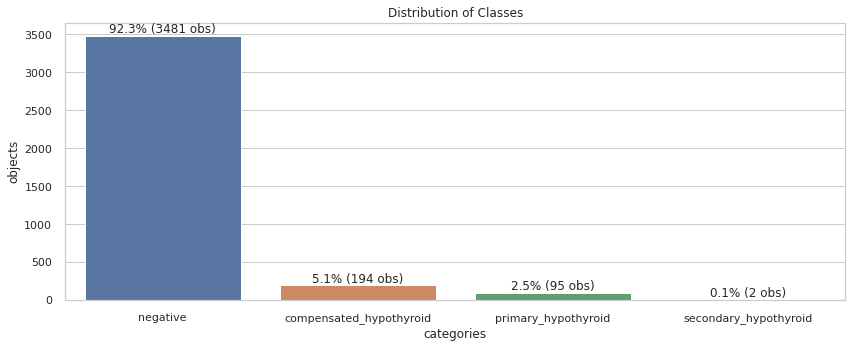

In [ ]:
target_distr(data, "Class")

There are only 2 observations of secondary hypothyroid. I don't think we can keep the current class structure. Primary and secondary hypothyroid is not the same disease, so we cant combine them into one. I think we should drop secondary hypothyroid class from our analysis.

In [ ]:
data = data.loc[~(data["Class"]=="secondary_hypothyroid")]

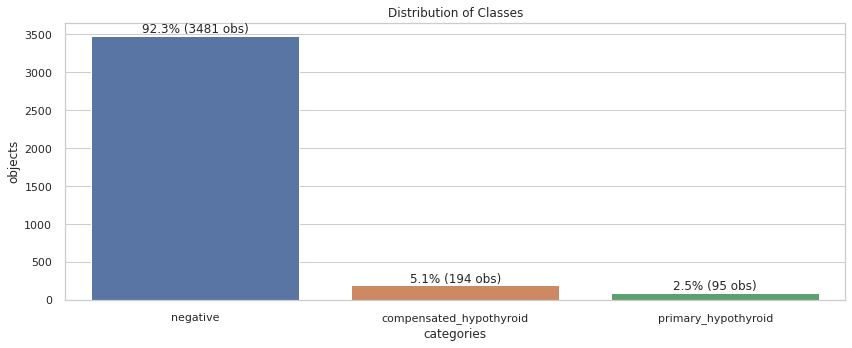

In [ ]:
target_distr(data, "Class")

Ok, now we're ready to move on

# Data Preparation. Part 1

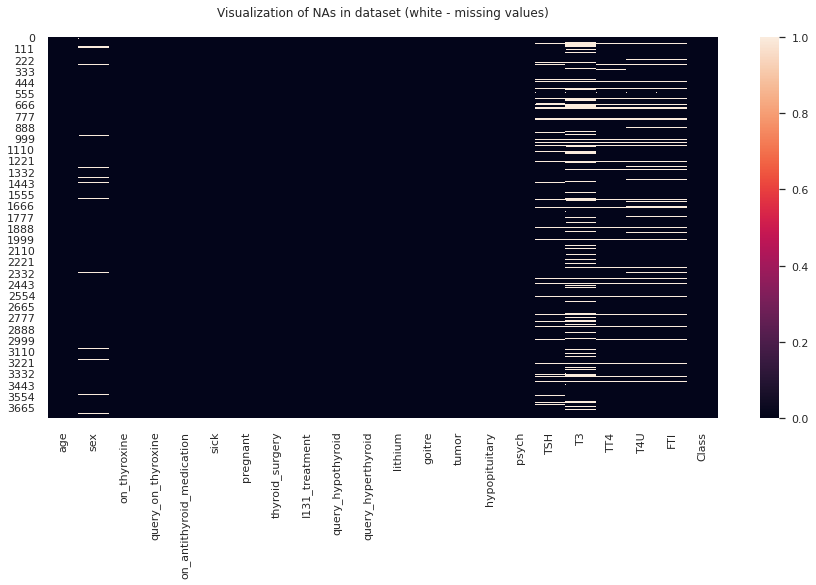

In [ ]:
# Now let's check nan
plt.figure(figsize=(15,7))
sns.heatmap(data.isna())
plt.title('Visualization of NAs in dataset (white - missing values)\n')
plt.show()

As we see, there are a lot of missing values in T3 column. Probably it will be useful to remove that column, but maybe KNNimputer will be a better choice

In [ ]:
# divide our feature into two groups: numerical and binary
numeric_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
categorical_culomns = ['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych']

In [ ]:
# let's replace all false values of categorical columns to 0 and true values to 1
data.loc[:, categorical_culomns] = data.loc[:, categorical_culomns].replace({"f":0, "t":1})
# Also let's binarize sex column
data.loc[:, 'sex'] = data.loc[:, 'sex'].replace({"F":0, "M":1})

In [ ]:
# Let's fill missing values in numericla features using KNN
# And for the sex feature let's fill missing values with the most frequent class
check_nan(data)

     Total   Percent
T3     769  0.203979
T4U    386  0.102387
FTI    384  0.101857
TSH    369  0.097878
TT4    231  0.061273
sex    150  0.039788
age      1  0.000265


In [ ]:
# Imputing sex feature
data.loc[data['sex'].isnull(), 'sex'] = 0

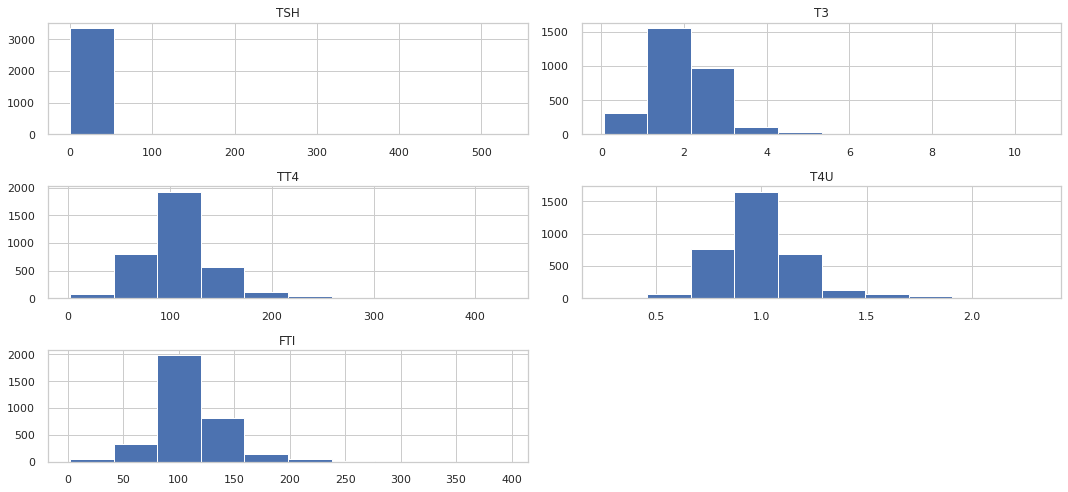

In [ ]:
# let's check distributions of our data before impute nans
data.loc[:, numeric_columns].hist(figsize=(15,7))
plt.tight_layout()
plt.show()

We have observations in which the age of objects exceeds 400. I suppose that we should drop them.  
And there are a lot of extreme values in our data. But I don't think that we should remove them. Maybe it's just a consequence of illness.


In [ ]:
data = data.loc[~(data["age"]>100)]

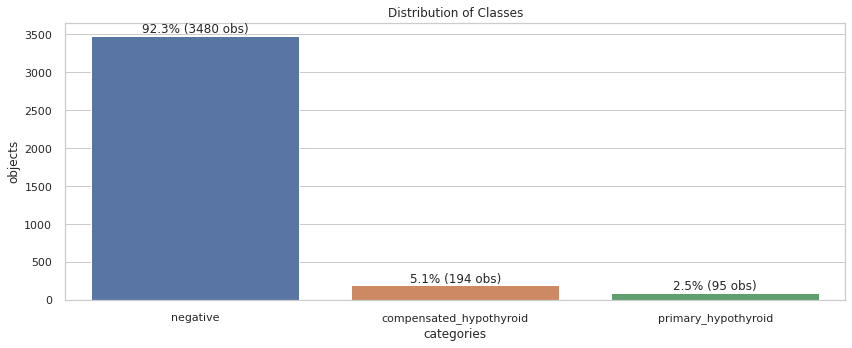

In [ ]:
# Check the distribution of target after the operation
# Everything is okay
target_distr(data, "Class")

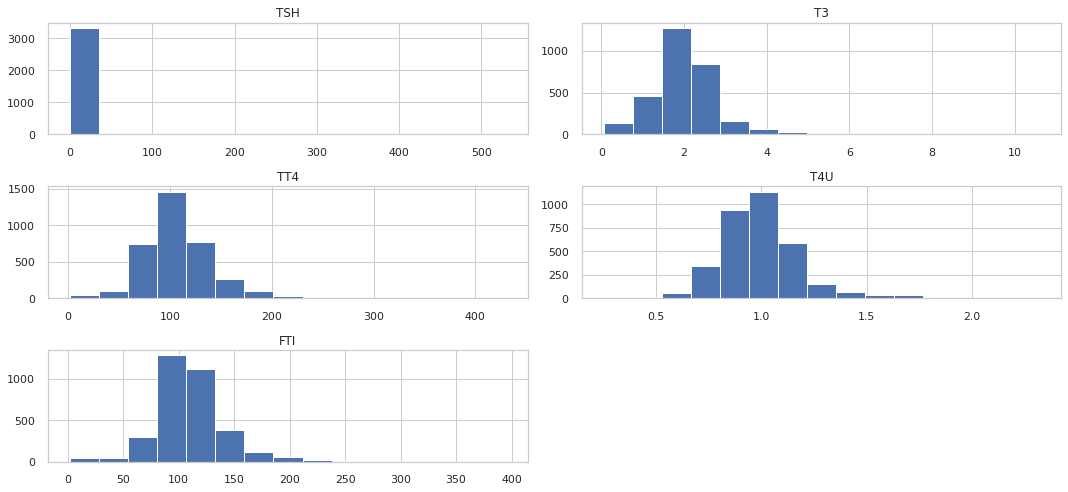

In [ ]:
data.loc[:, numeric_columns].hist(figsize=(15,7), bins=15)
plt.tight_layout()
plt.show()

In [ ]:
# Now we are ready to impute our nans
# I will use all available observations for EDA purposes
# And I won't separate data into train / test for now
# I will fit KNNimputer in a whole dataset
imputer = KNNImputer(n_neighbors=5)
data.iloc[:, :-1] = imputer.fit_transform(data.iloc[:, :-1])

In [ ]:
check_nan(data)

There are no missing values


# EDA & FE

## Univariate analysis

### Numerical Features

Now let's check the features distributions.

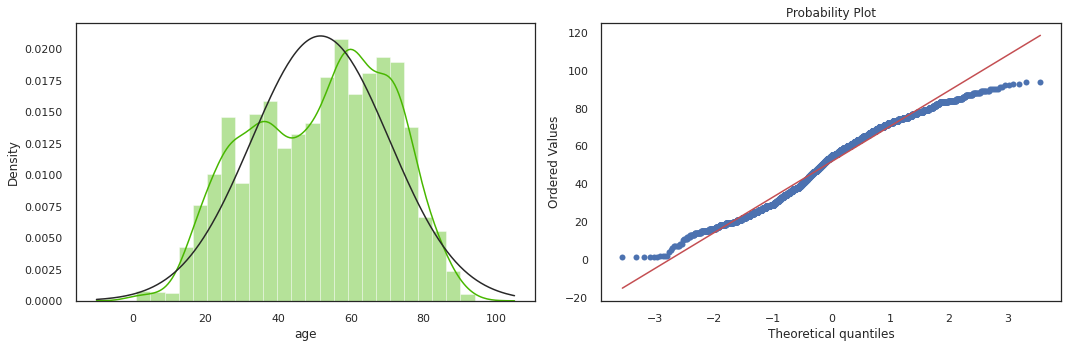

Skewness: -0.211226
Kurtosis: -0.887710 

null hypothesis: x comes from a normal distribution
p_value = 2.0443671189853567e-111, 509.7437141160221


In [ ]:
# it looks like a mixture of 2 normal distributions
# there is no way to normalize it 
distribution_plot(data.copy(), target_col="age")

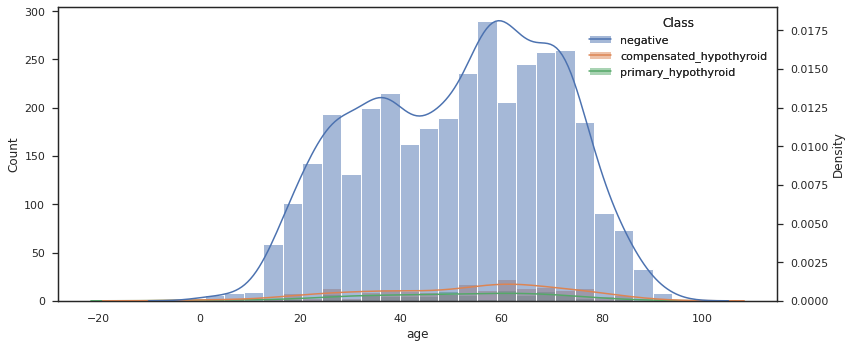

In [ ]:
hist_hue(data, target_hue_list=["age", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "age"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "age"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "age"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=0.8651315328303094, pvalue=0.6488421797070691)

There is not enough evidence at the level 0.05 to conclude that there is a difference in age between groups. We can conclude that the feature is pretty useless.

In [ ]:
data.drop(columns=["age"], inplace=True)

---
---

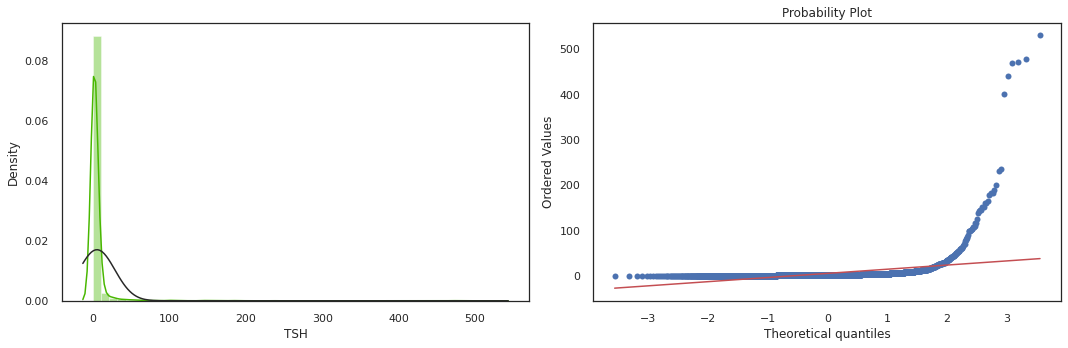

Skewness: 14.445743
Kurtosis: 259.529738 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 7128.544845503123
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


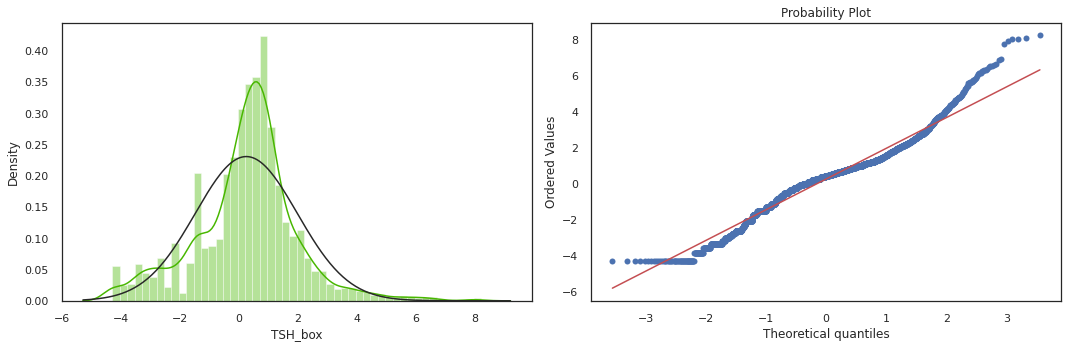

Skewness: 0.064127
Kurtosis: 1.609280 

null hypothesis: x comes from a normal distribution
p_value = 3.5780860872186033e-31, 140.2106196757356
The null hypothesis still can be rejected
But we did our best


In [ ]:
# It looks like a log distribution 
# let's apply a box-cox transformation to it
data.loc[:, 'TSH'], lmbda_tsh = dist_graph(data.copy(), target_col='TSH')

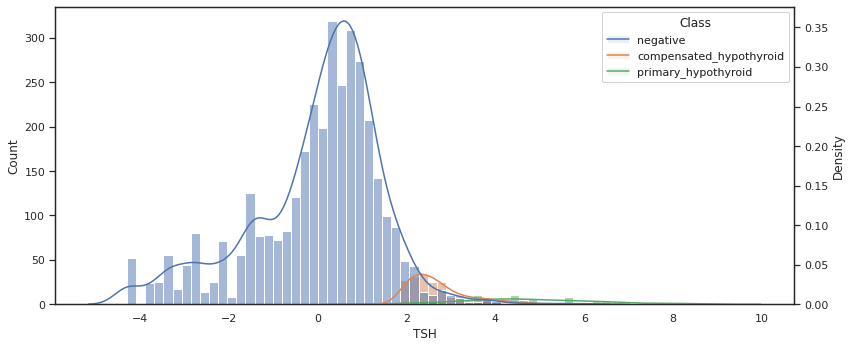

In [ ]:
hist_hue(data, target_hue_list=["TSH", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "TSH"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "TSH"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "TSH"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=754.2430852863326, pvalue=1.6527037907899461e-164)

There is sufficient evidence at the level 0.05 to conclude that there is a difference in median TSH between groups.

---
---

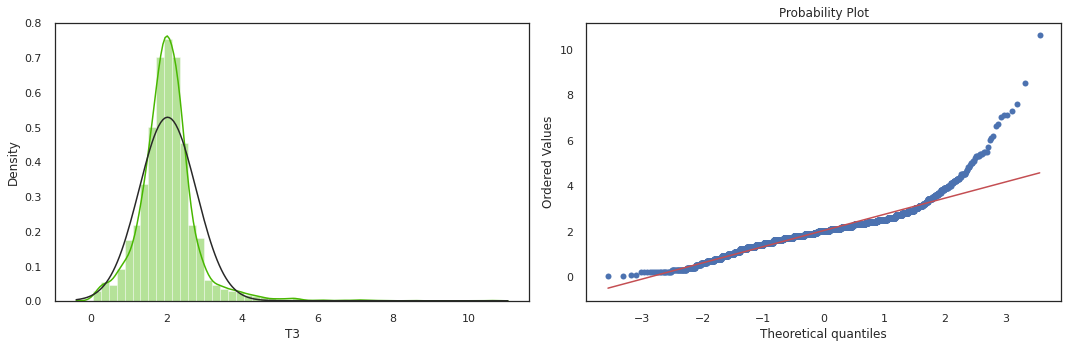

Skewness: 1.764850
Kurtosis: 11.637180 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1688.5231483785703
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


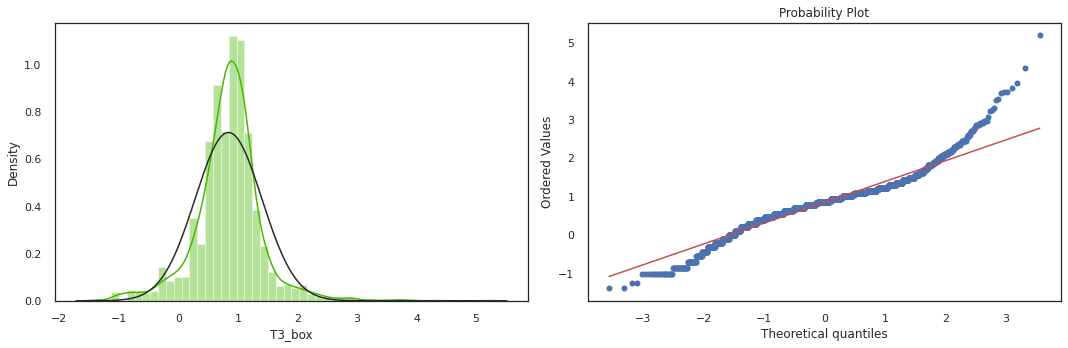

Skewness: 0.280980
Kurtosis: 4.442886 

null hypothesis: x comes from a normal distribution
p_value = 3.7782408661154325e-94, 430.2274804389318
The null hypothesis still can be rejected
But we did our best


In [ ]:
 # Here we see a slight positive skewness
 # power transformation can fix it 
 data.loc[:, 'T3'], lmbda_tsh = dist_graph(data.copy(), target_col='T3')

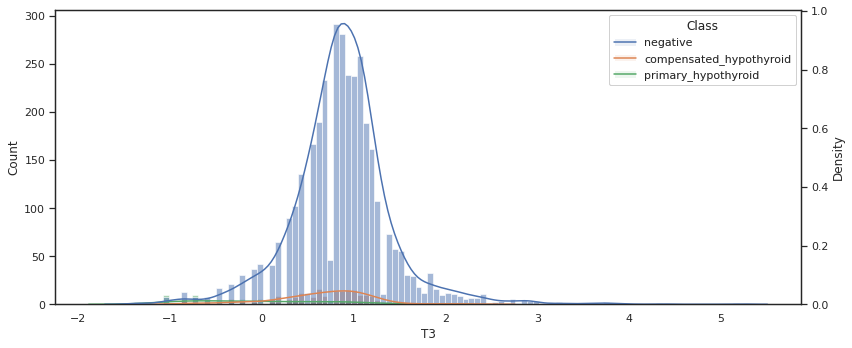

In [ ]:
hist_hue(data, target_hue_list=["T3", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "T3"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "T3"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "T3"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=144.13240159168868, pvalue=5.035547101577605e-32)

There is sufficient evidence at the level 0.05 to conclude that there is a difference in median T3 between groups. But it's not such strong dependence like in TSH case

---
---

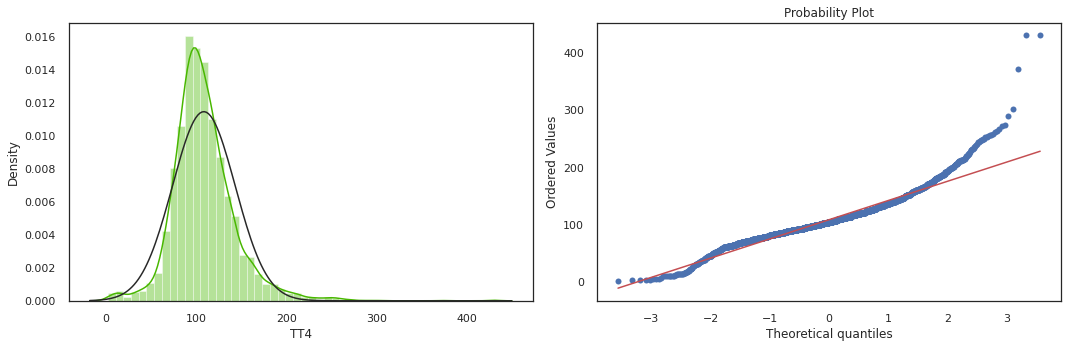

Skewness: 1.296225
Kurtosis: 6.935563 

null hypothesis: x comes from a normal distribution
p_value = 3.036106083657877e-257, 1181.3075861972611
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


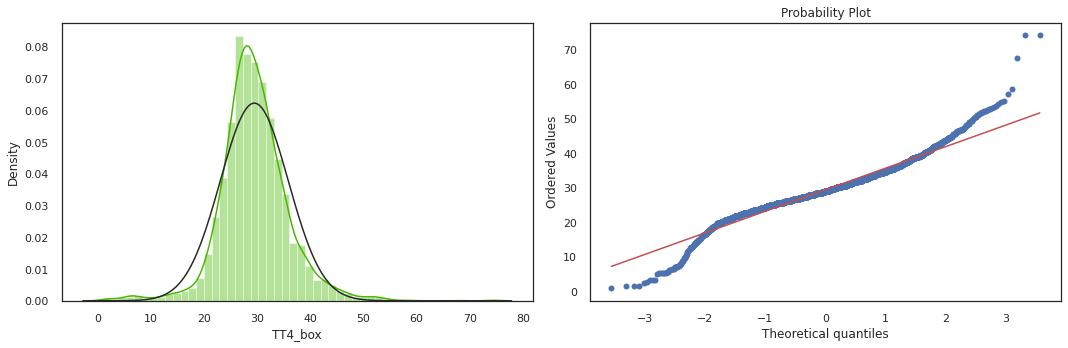

Skewness: 0.283665
Kurtosis: 3.919224 

null hypothesis: x comes from a normal distribution
p_value = 4.513795271451695e-86, 393.03035934850465
The null hypothesis still can be rejected
But we did our best


In [ ]:
 # Here we see a slight positive skewness
 # power transformation can fix it 
 data.loc[:, 'TT4'], lmbda_tsh = dist_graph(data.copy(), target_col='TT4')

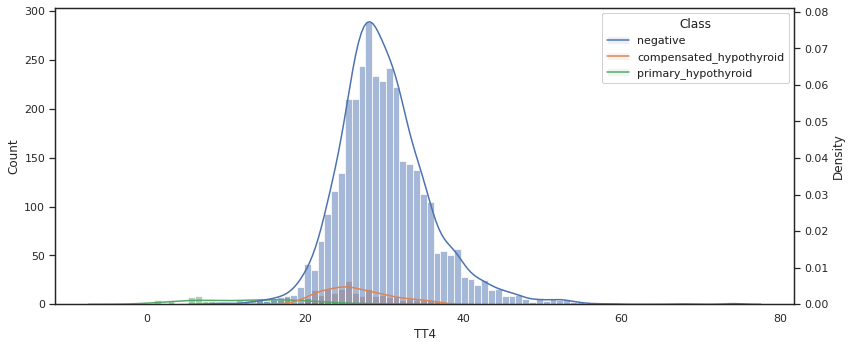

In [ ]:
hist_hue(data, target_hue_list=["TT4", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "TT4"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "TT4"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "TT4"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=331.03774607344155, pvalue=1.3063717770696967e-72)

There is sufficient evidence at the level 0.05 to conclude that there is a difference in median TT4 between groups.

---
---

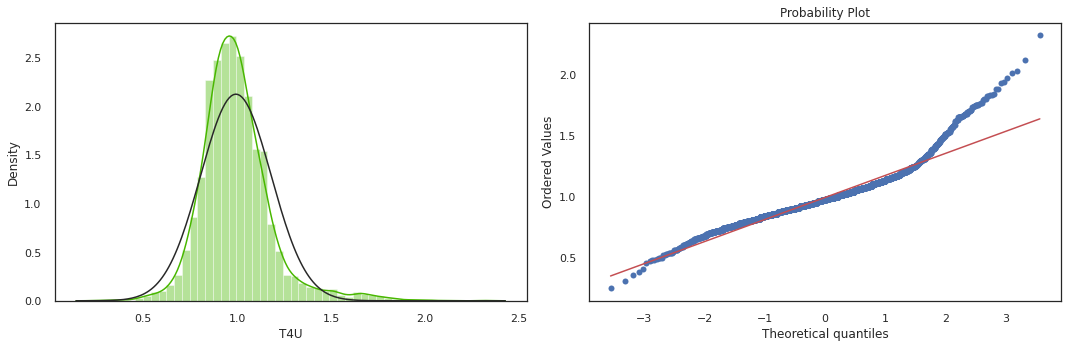

Skewness: 1.270815
Kurtosis: 4.506812 

null hypothesis: x comes from a normal distribution
p_value = 4.8088292842255744e-222, 1019.206873964476
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


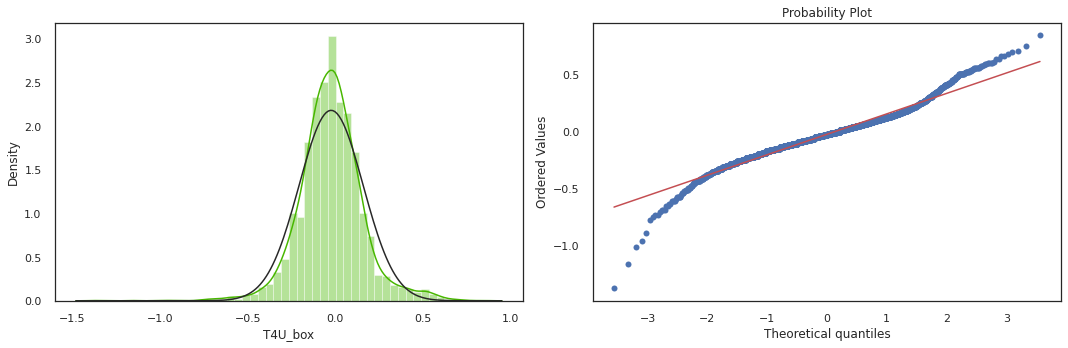

Skewness: 0.002273
Kurtosis: 3.286164 

null hypothesis: x comes from a normal distribution
p_value = 1.3095049496810403e-64, 294.19159357367056
The null hypothesis still can be rejected
But we did our best


In [ ]:
 # Here we see a slight positive skewness
 # power transformation can fix it 
 data.loc[:, 'T4U'], lmbda_tsh = dist_graph(data.copy(), target_col='T4U')

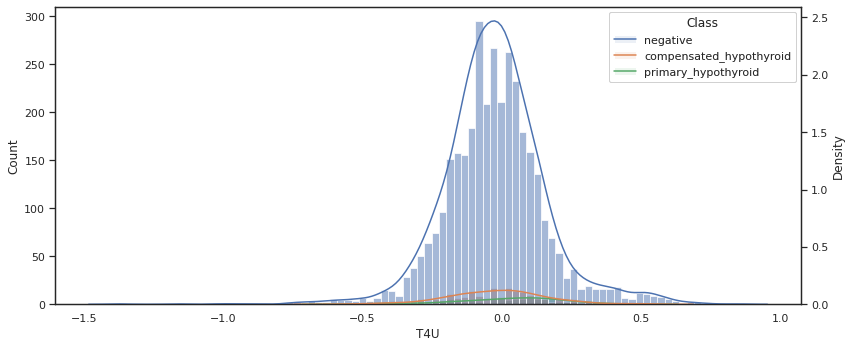

In [ ]:
hist_hue(data, target_hue_list=["T4U", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "T4U"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "T4U"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "T4U"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=13.007257217109231, pvalue=0.00149799368644138)

There is sufficient evidence at the level 0.05 to conclude that there is a difference in median T4U between groups. Maybe it will be useful to test model without this feature

---
---

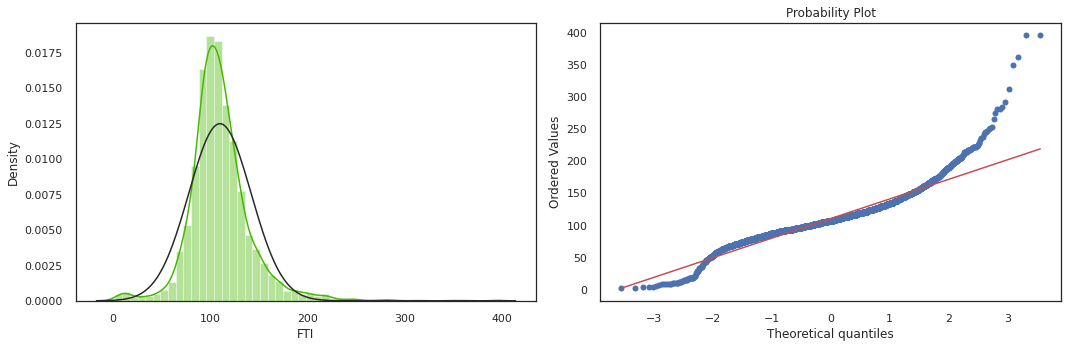

Skewness: 1.347630
Kurtosis: 8.344395 

null hypothesis: x comes from a normal distribution
p_value = 2.087026162855666e-279, 1283.3710015624301
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


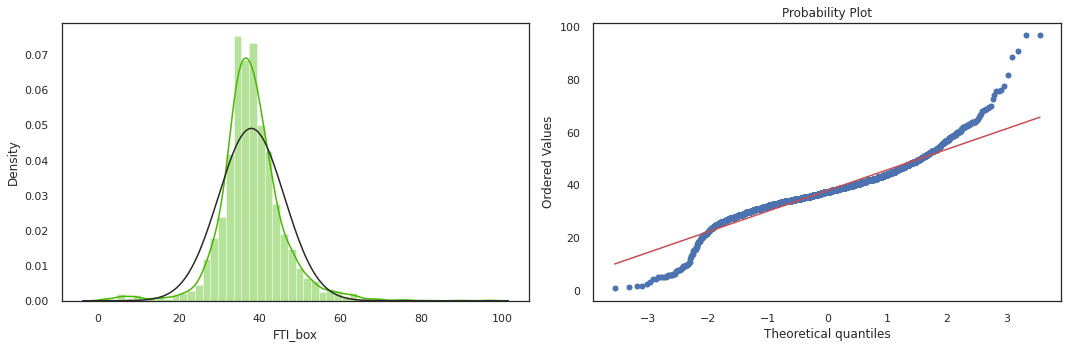

Skewness: 0.401205
Kurtosis: 5.647139 

null hypothesis: x comes from a normal distribution
p_value = 4.005905249478691e-121, 554.4500533349354
The null hypothesis still can be rejected
But we did our best


In [ ]:
 # Here we see a slight positive skewness
 # power transformation can fix it 
 data.loc[:, 'FTI'], lmbda_tsh = dist_graph(data.copy(), target_col='FTI')

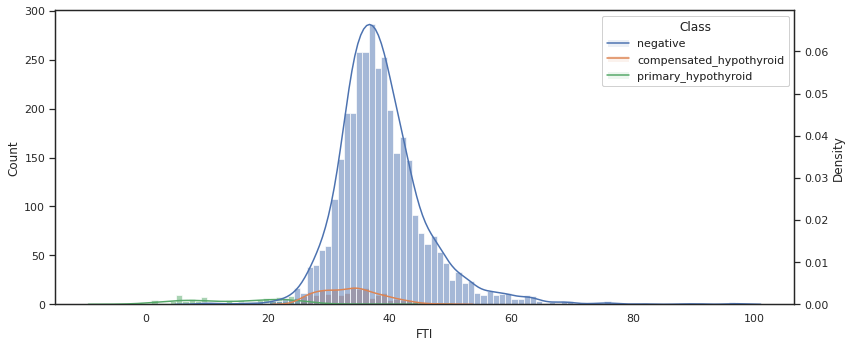

In [ ]:
hist_hue(data, target_hue_list=["FTI", "Class"])

H0: median_1 = median_2 = median_3  
H1: The means are not all equal

In [ ]:
sample1 = data.loc[data["Class"] == "negative", "FTI"].values
sample2 = data.loc[data["Class"] == "primary_hypothyroid", "FTI"].values
sample3 = data.loc[data["Class"] == "compensated_hypothyroid", "FTI"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2, sample3)

KruskalResult(statistic=371.0857562660486, pvalue=2.628765644943441e-81)

There is sufficient evidence at the level 0.05 to conclude that there is a difference in median FTI between groups.

### Categorical Features

#### Useful features

In [ ]:
# They are far from constant

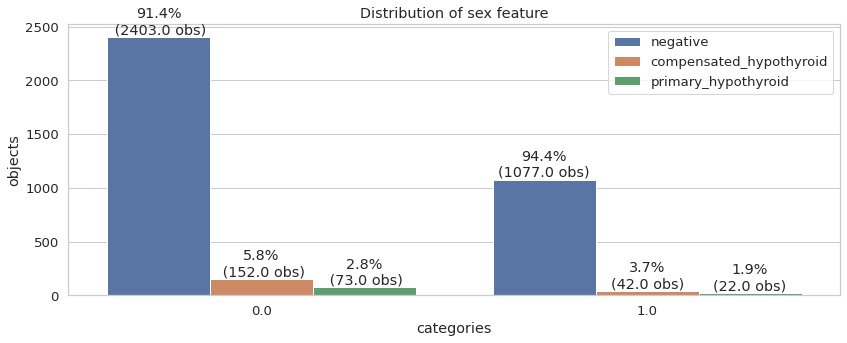

In [ ]:
plot_func(data=data, column_x="sex", num_classes=3, column_y='Class')

---
---

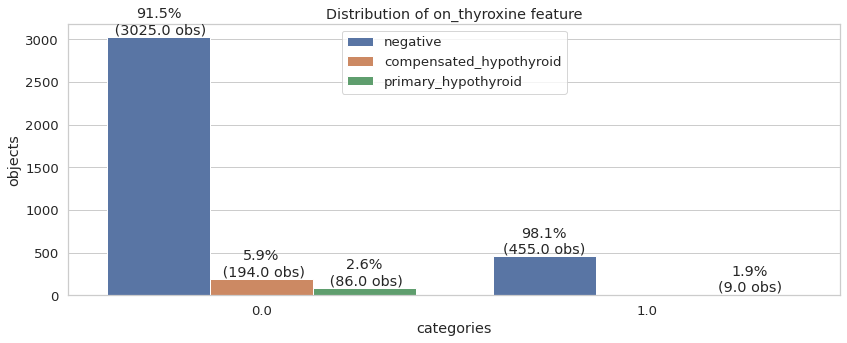

In [ ]:
plot_func(data=data, column_x="on_thyroxine", num_classes=3, column_y='Class')

---
---

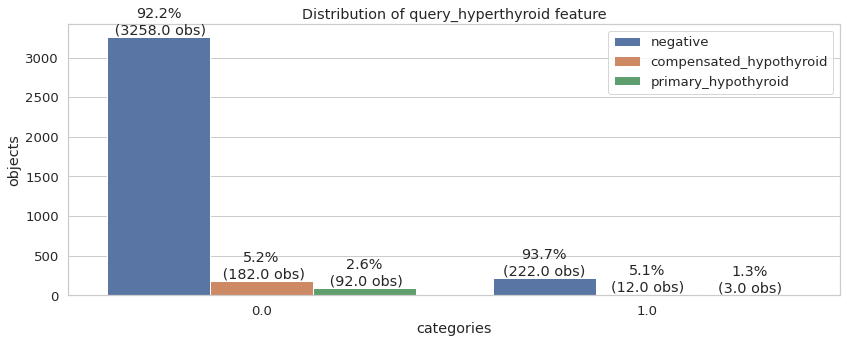

In [ ]:
plot_func(data=data, column_x="query_hyperthyroid", num_classes=3, column_y='Class')

---
---

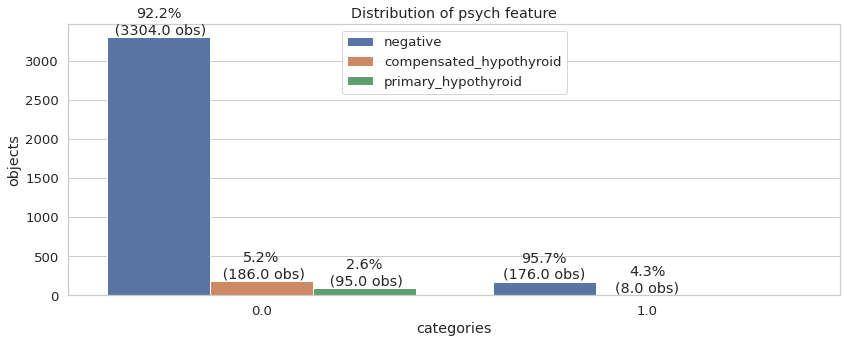

In [ ]:
plot_func(data=data, column_x="psych", num_classes=3, column_y='Class')

---
---

Pregnant women with hypothyroidism have one peculiarity. Symptoms may decrease as pregnancy progresses. This is due to an increase in the activity of the fetal thyroid gland and the supply of its hormones to the mother as compensation.

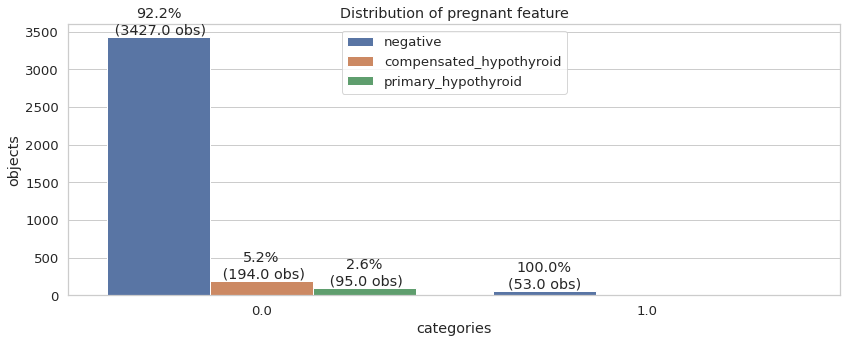

In [ ]:
plot_func(data=data, column_x="pregnant", num_classes=3, column_y='Class')

#### Pretty useless features

---
---

In [ ]:
# There are not enough obs in class 1
# But maybe it could be usefull to add them into model

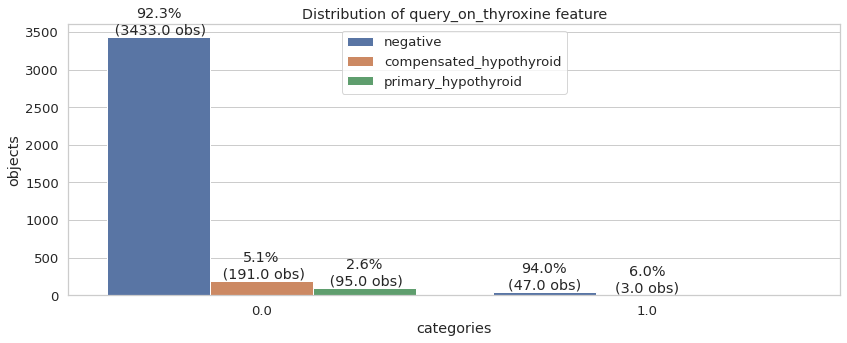

In [ ]:
plot_func(data=data, column_x="query_on_thyroxine", num_classes=3, column_y='Class')

---
---

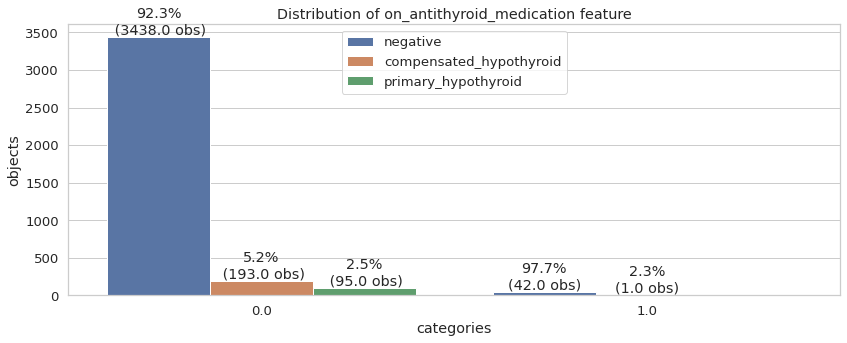

In [ ]:
plot_func(data=data, column_x="on_antithyroid_medication", num_classes=3, column_y='Class')

---
---

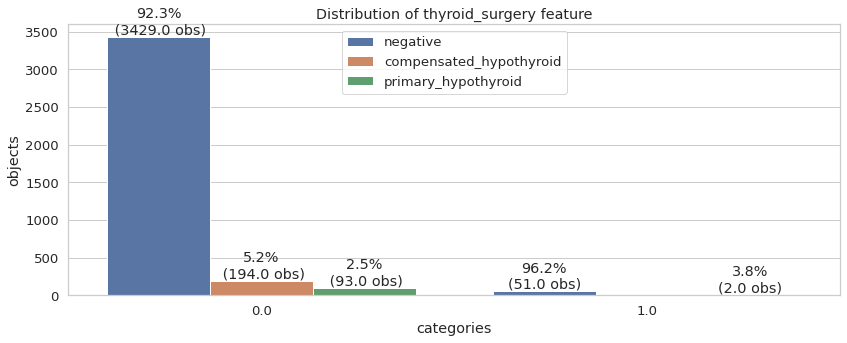

In [ ]:
plot_func(data=data, column_x="thyroid_surgery", num_classes=3, column_y='Class')

---
---

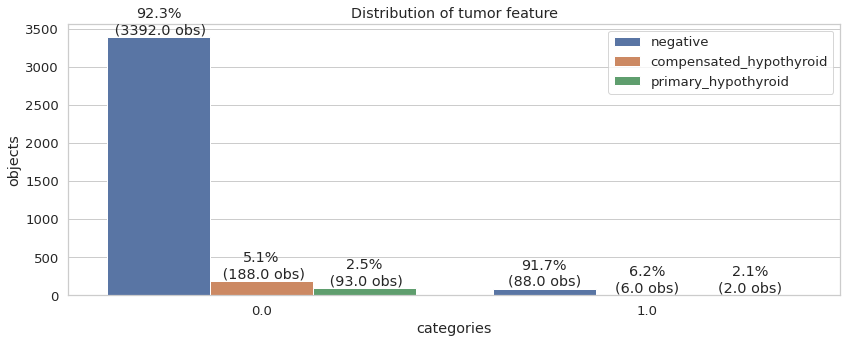

In [ ]:
plot_func(data=data, column_x="tumor", num_classes=3, column_y='Class')

---
---

#### Absolutly useless features

In [ ]:
# All of them are basically constant features. 
# I don't think that we need them in our model

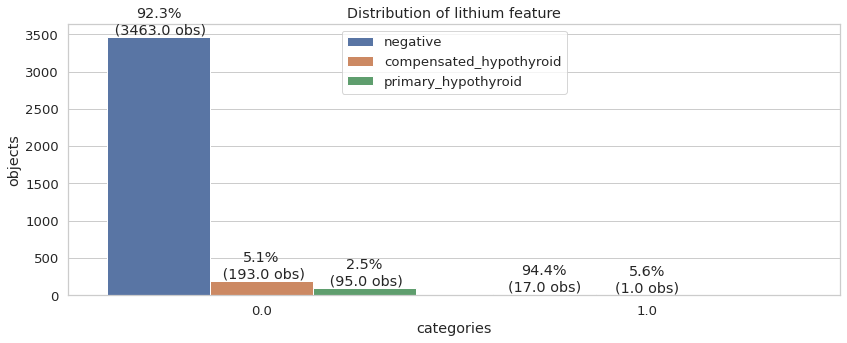

In [ ]:
plot_func(data=data, column_x="lithium", num_classes=3, column_y='Class')

---
---

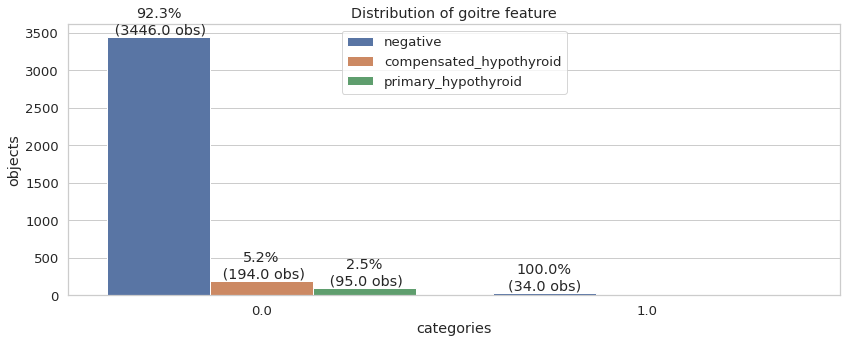

In [ ]:
plot_func(data=data, column_x="goitre", num_classes=3, column_y='Class')

---
---

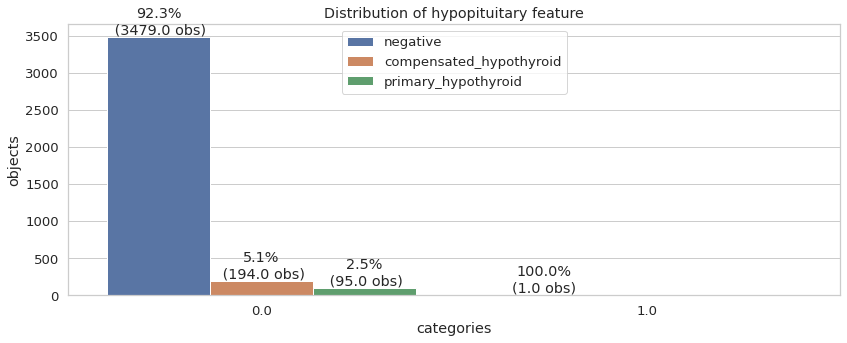

In [ ]:
plot_func(data=data, column_x="hypopituitary", num_classes=3, column_y='Class')

In [ ]:
data.drop(columns=["hypopituitary", "goitre", "lithium"], inplace=True)

categorical_culomns.remove("hypopituitary")
categorical_culomns.remove("goitre")
categorical_culomns.remove("lithium")

## Multivariate analysis

### Categorical features

#### FacetGrid

Let's take a look at the most promising regressors

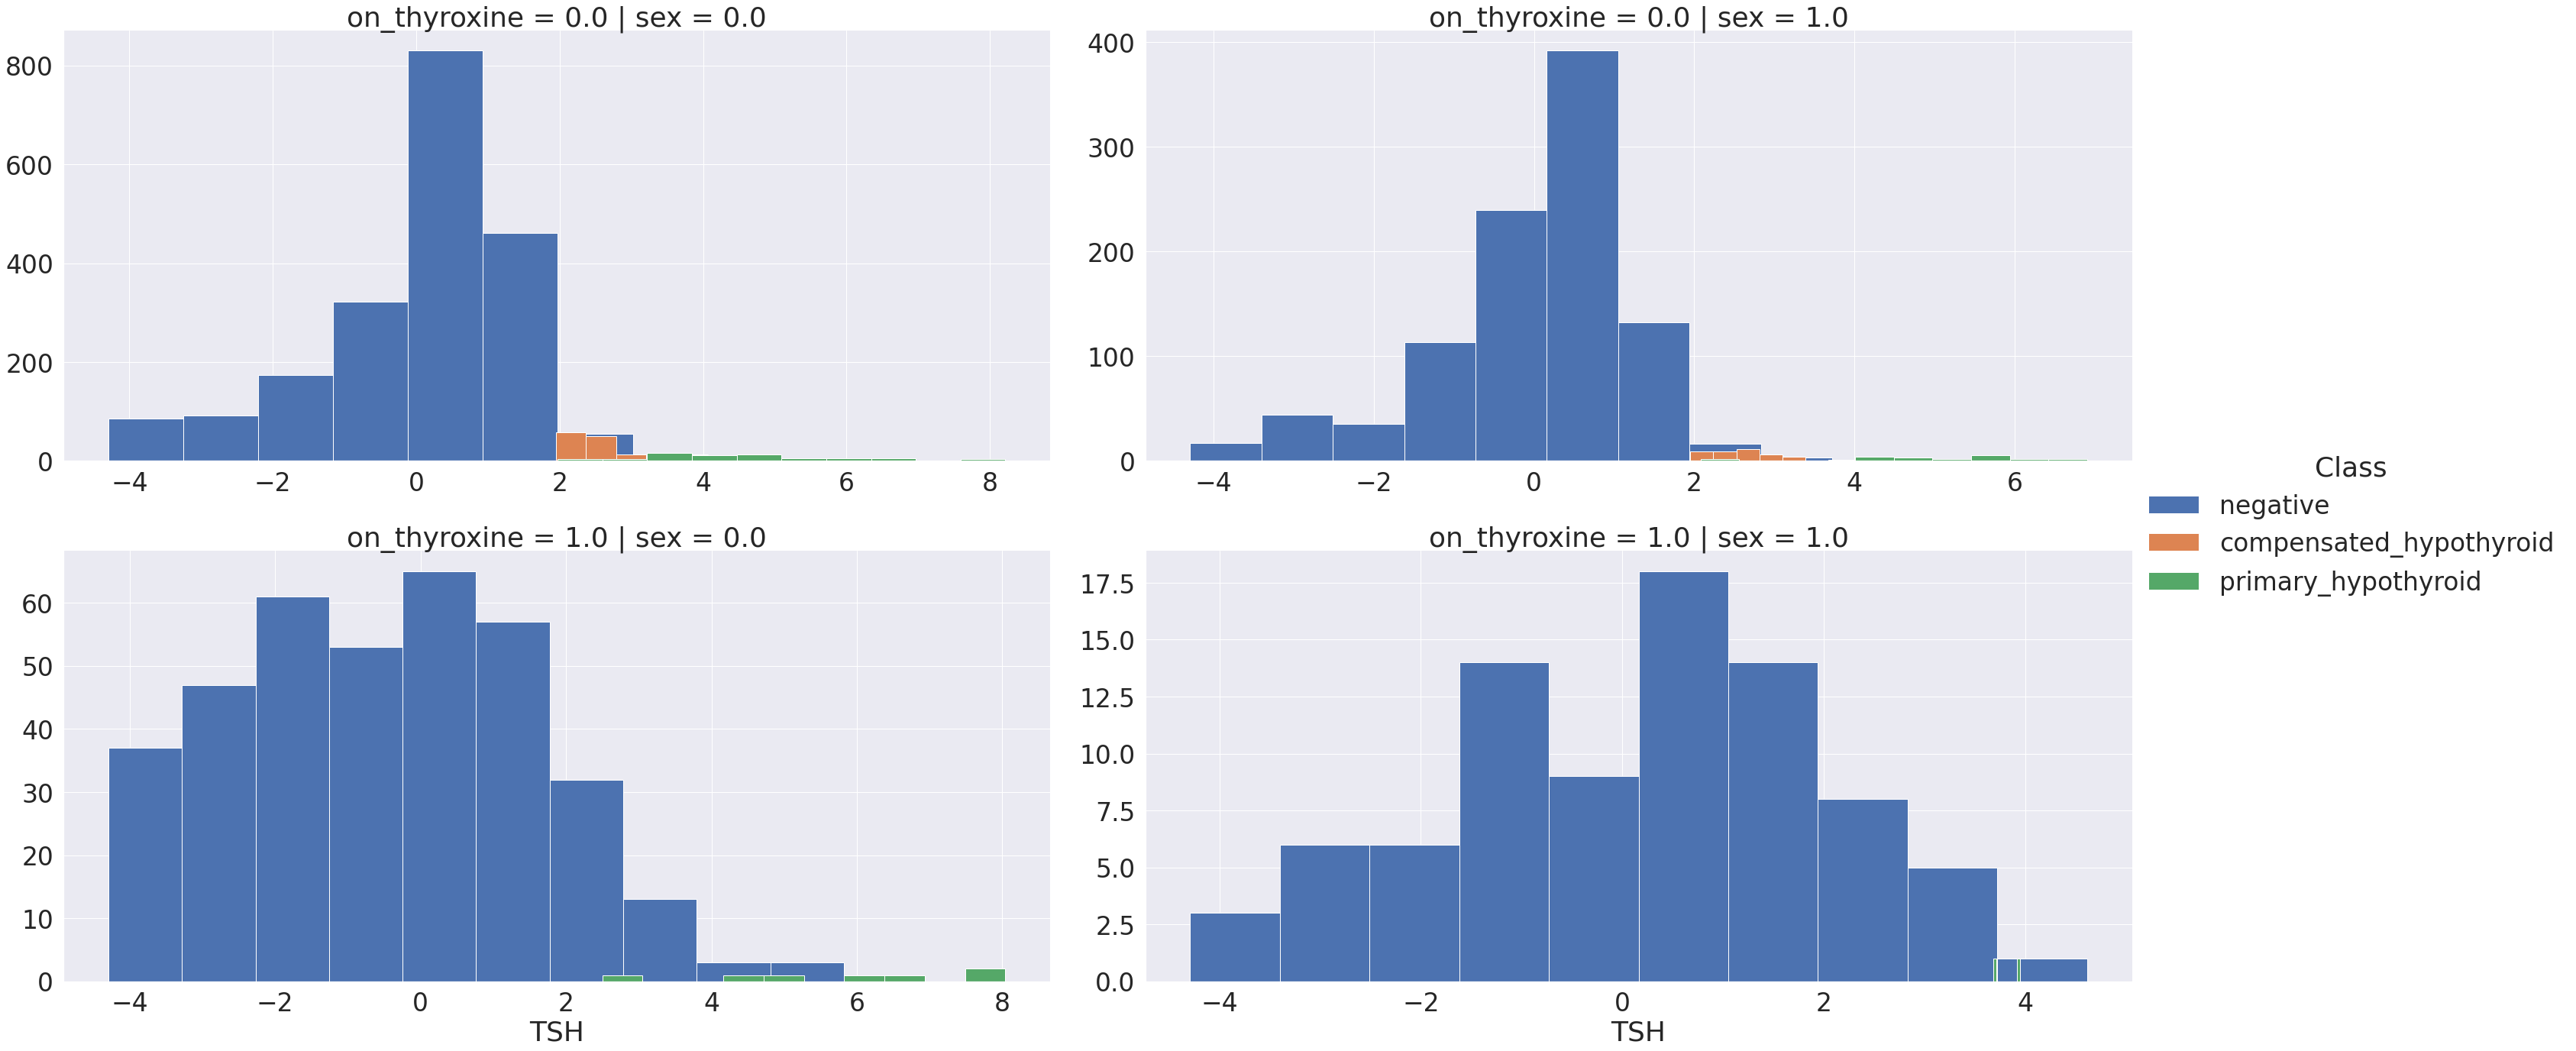

In [ ]:
sns.set(font_scale=3)
g = sns.FacetGrid(
    data,
    col='sex',
    row='on_thyroxine',
    sharex=False,
    sharey=False,
    height=10,
    aspect=2,
    hue='Class'
)
g = (g.map(plt.hist, 'TSH').add_legend())
plt.show()

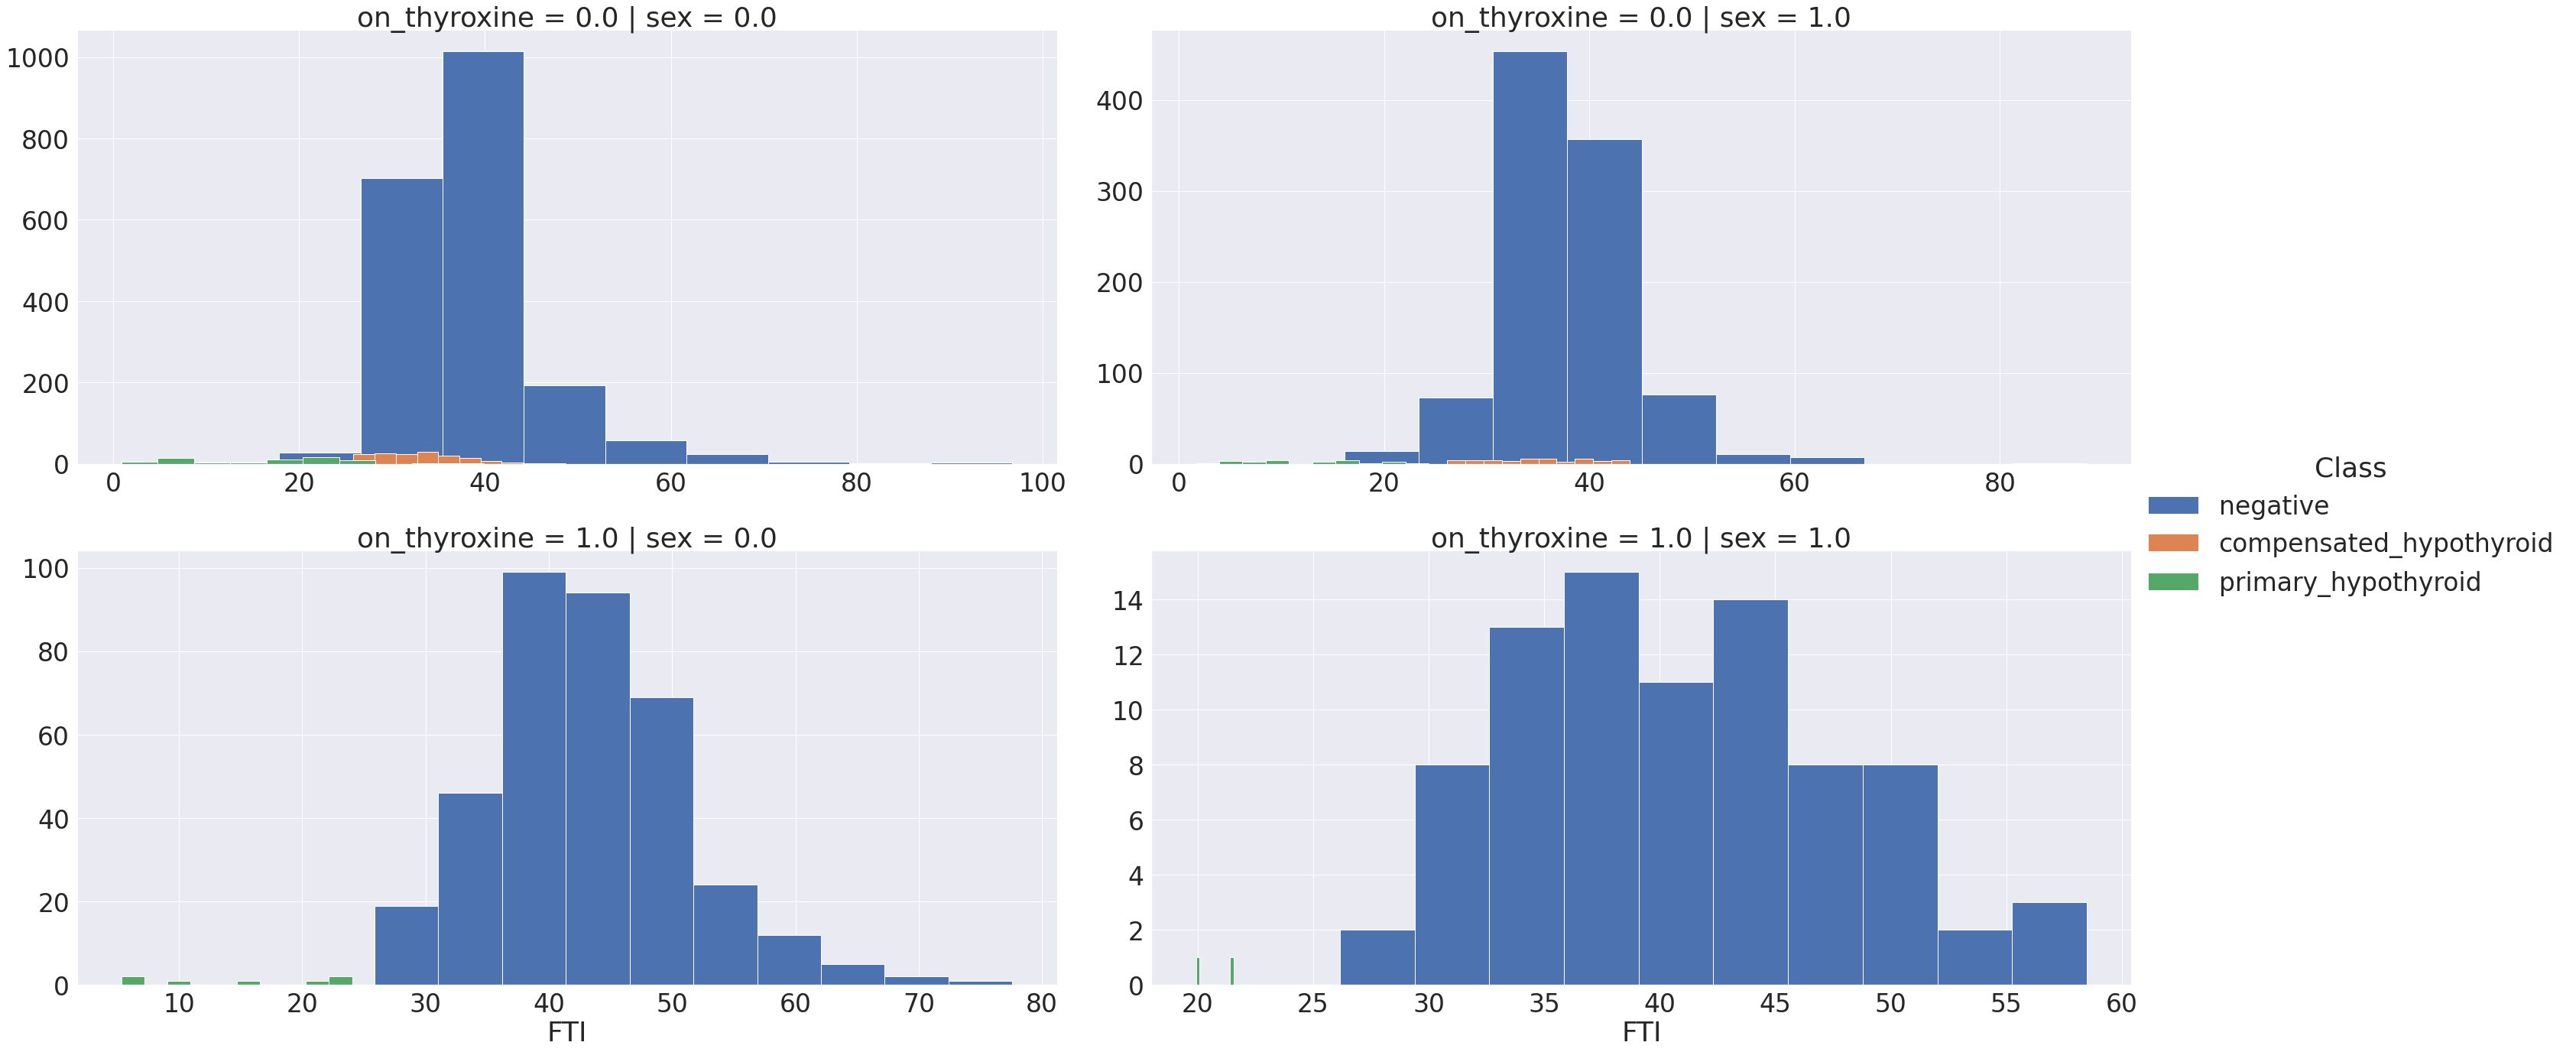

In [ ]:
sns.set(font_scale=3)
g = sns.FacetGrid(
    data,
    col='sex',
    row='on_thyroxine',
    sharex=False,
    sharey=False,
    height=10,
    aspect=2,
    hue='Class'
)
g = (g.map(plt.hist, 'FTI').add_legend())
plt.show()

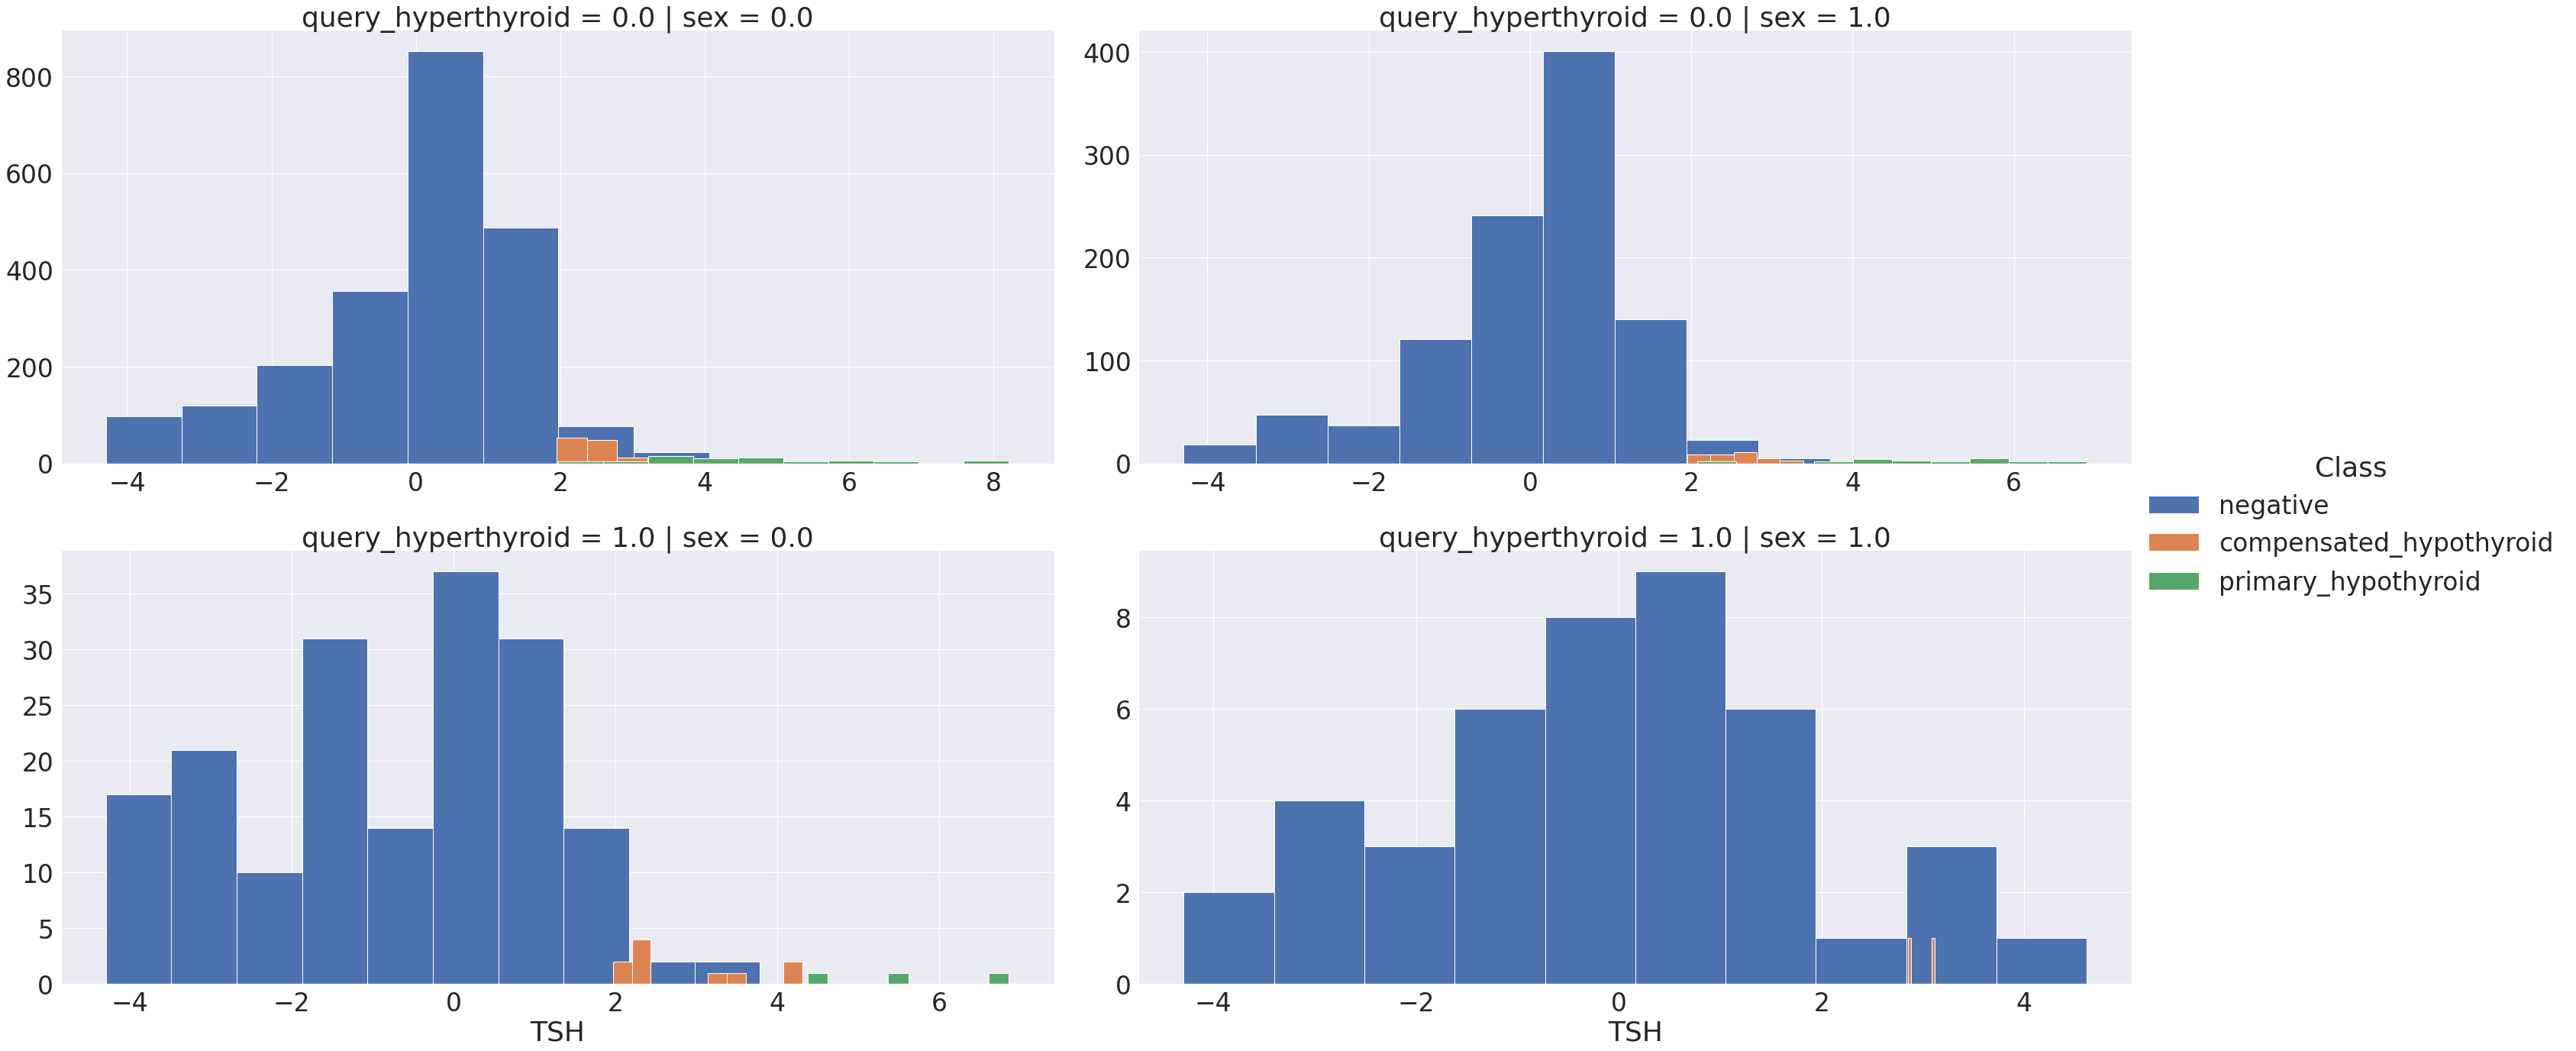

In [ ]:
sns.set(font_scale=3)
g = sns.FacetGrid(
    data,
    col='sex',
    row='query_hyperthyroid',
    sharex=False,
    sharey=False,
    height=10,
    aspect=2,
    hue='Class'
)
g = (g.map(plt.hist, 'TSH').add_legend())
plt.show()

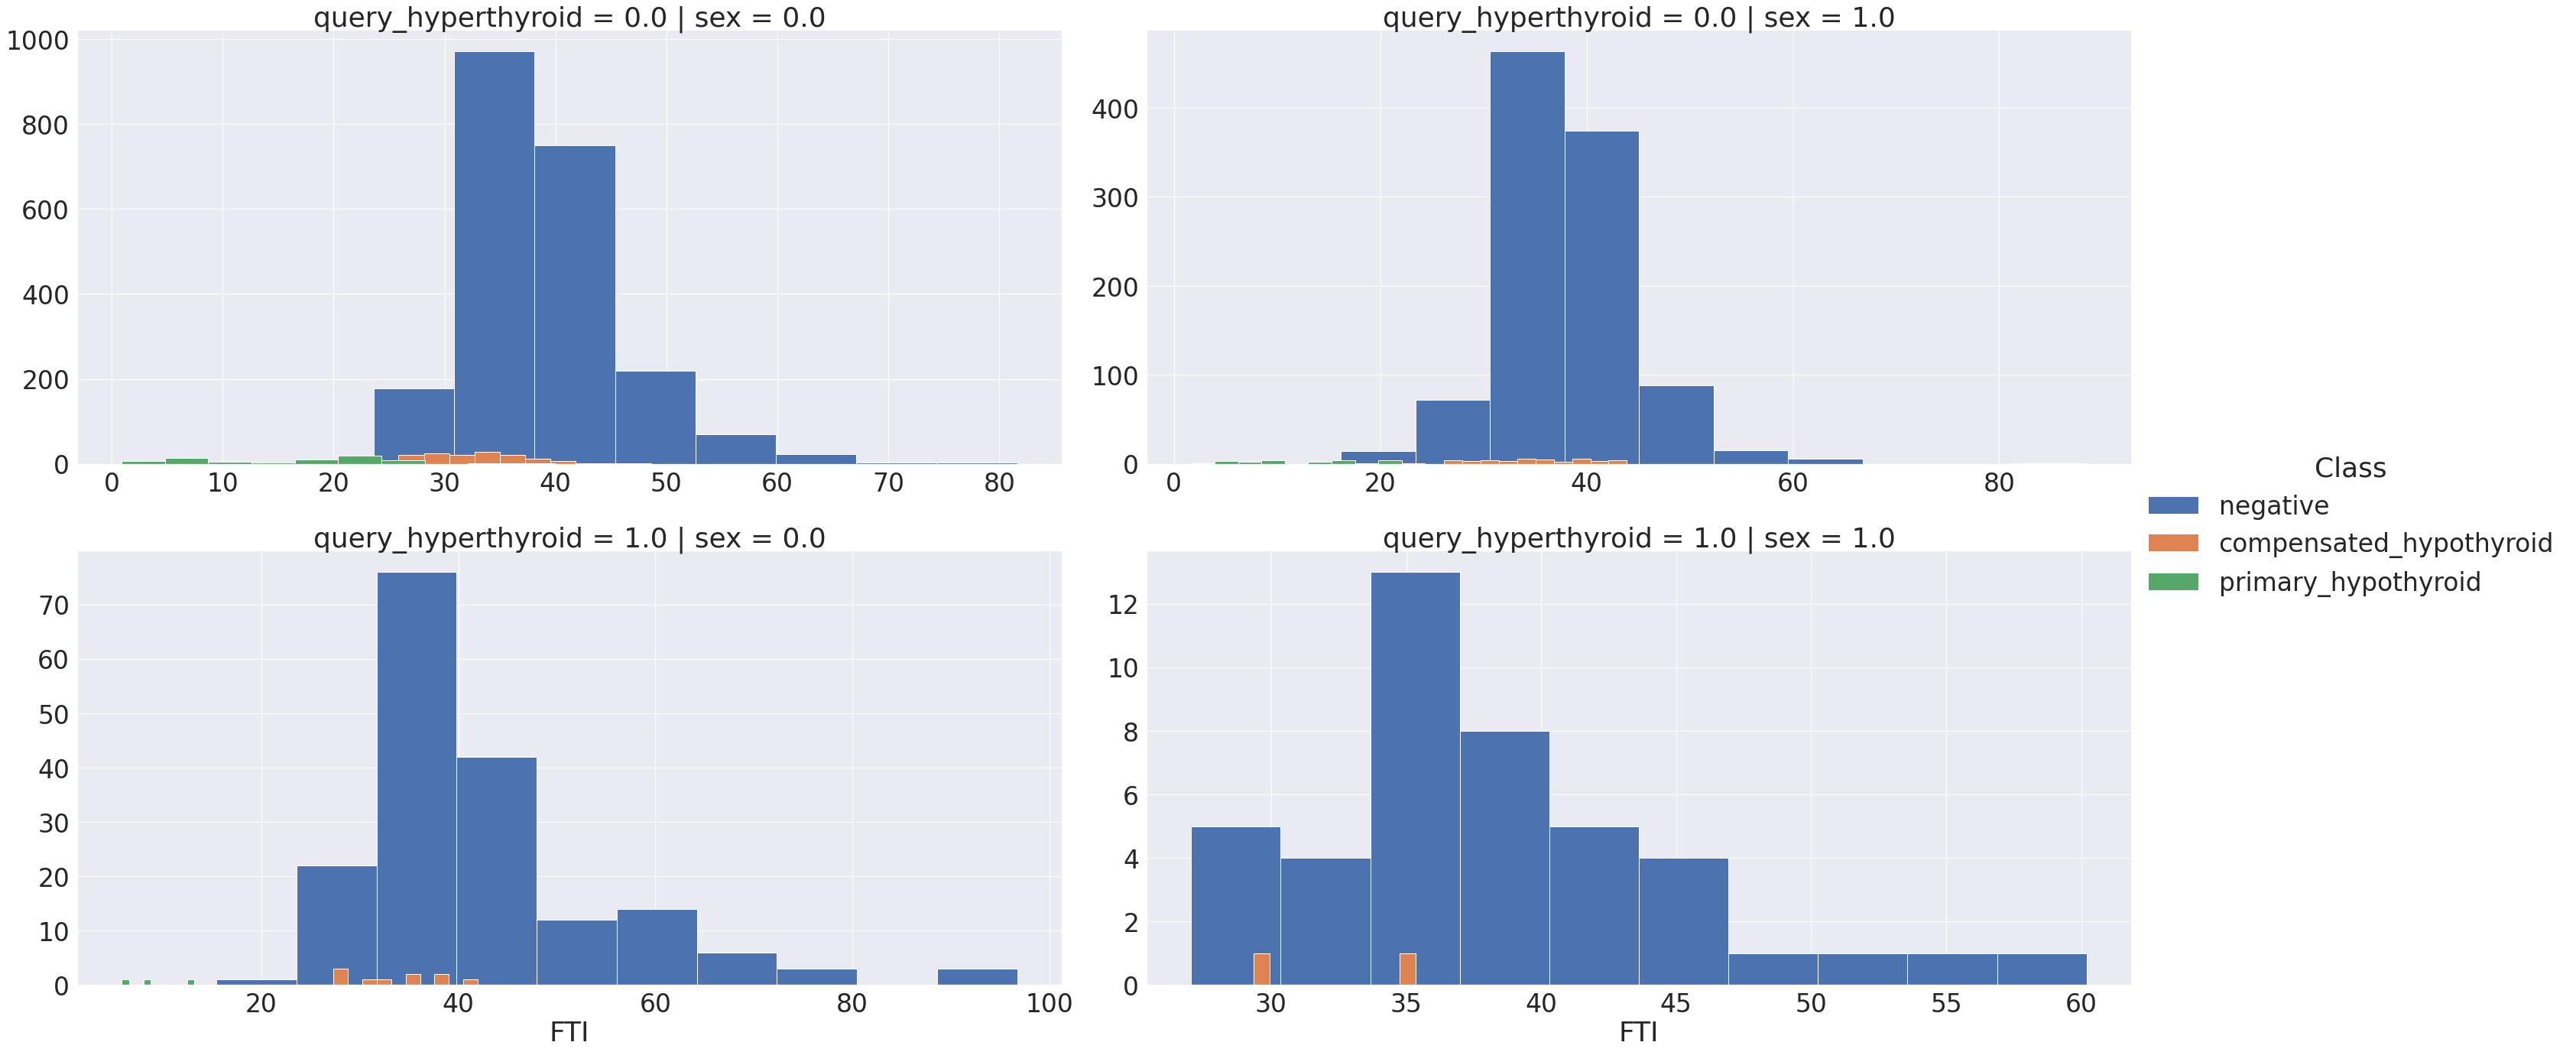

In [ ]:
sns.set(font_scale=3)
g = sns.FacetGrid(
    data,
    col='sex',
    row='query_hyperthyroid',
    sharex=False,
    sharey=False,
    height=10,
    aspect=2,
    hue='Class'
)
g = (g.map(plt.hist, 'FTI').add_legend())
plt.show()

Looks promising

####  Correaltion

In [ ]:
data_corr = pd.DataFrame(index=categorical_culomns, columns=categorical_culomns)

In [ ]:
for column in data_corr.columns:
    for index in data_corr.index:
        contingency_table = pd.crosstab(data.loc[:,column], data.loc[:, index])
        data_corr.loc[index, column] = matthews_cc(contingency_table)

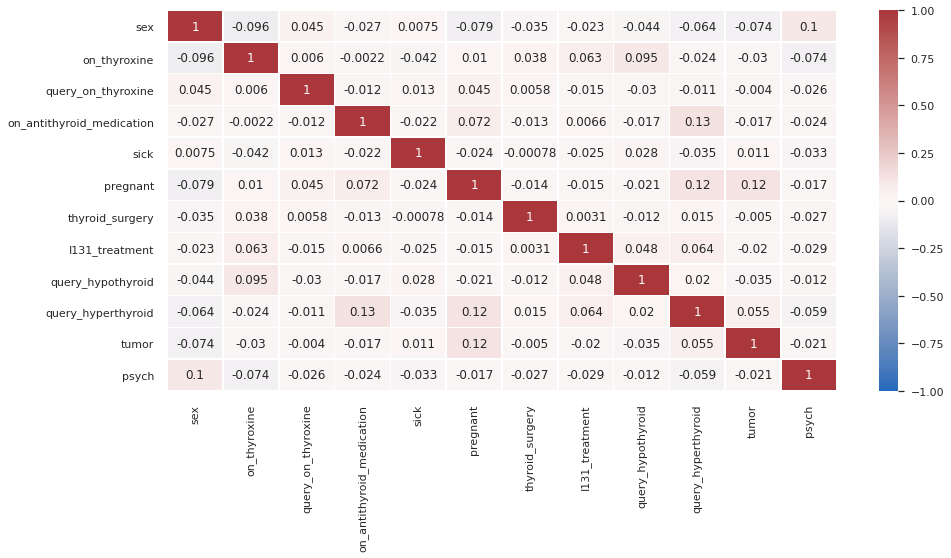

In [ ]:
# there is no multicollinearity
# seem like it's just consequences of unbalanced classes
sns.set(font_scale=1)
corr_0 = data_corr.astype(float).copy()
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_0, vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

### Numerical features analysis

#### Pairplot

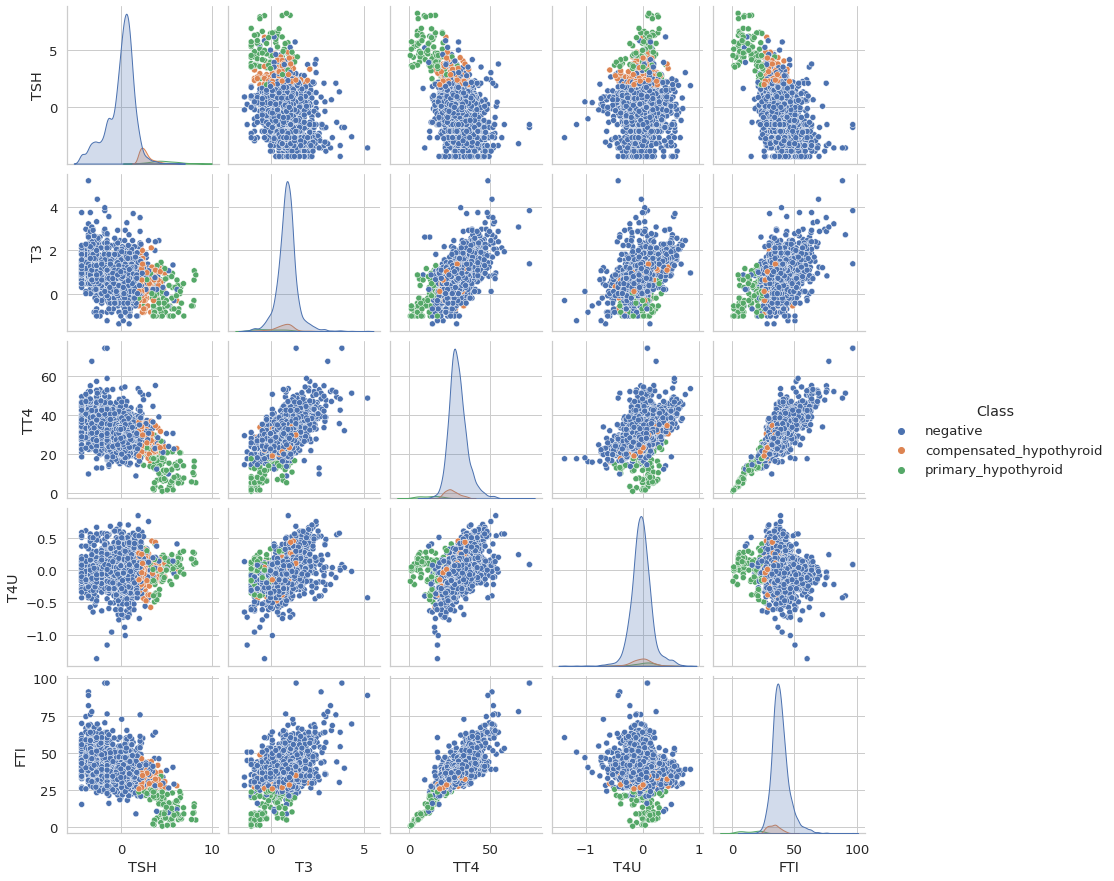

In [ ]:
# Classes are visually separable
sns.pairplot(data.loc[:, numeric_columns + ["Class"]], hue="Class")
plt.show()

#### Scatter plot

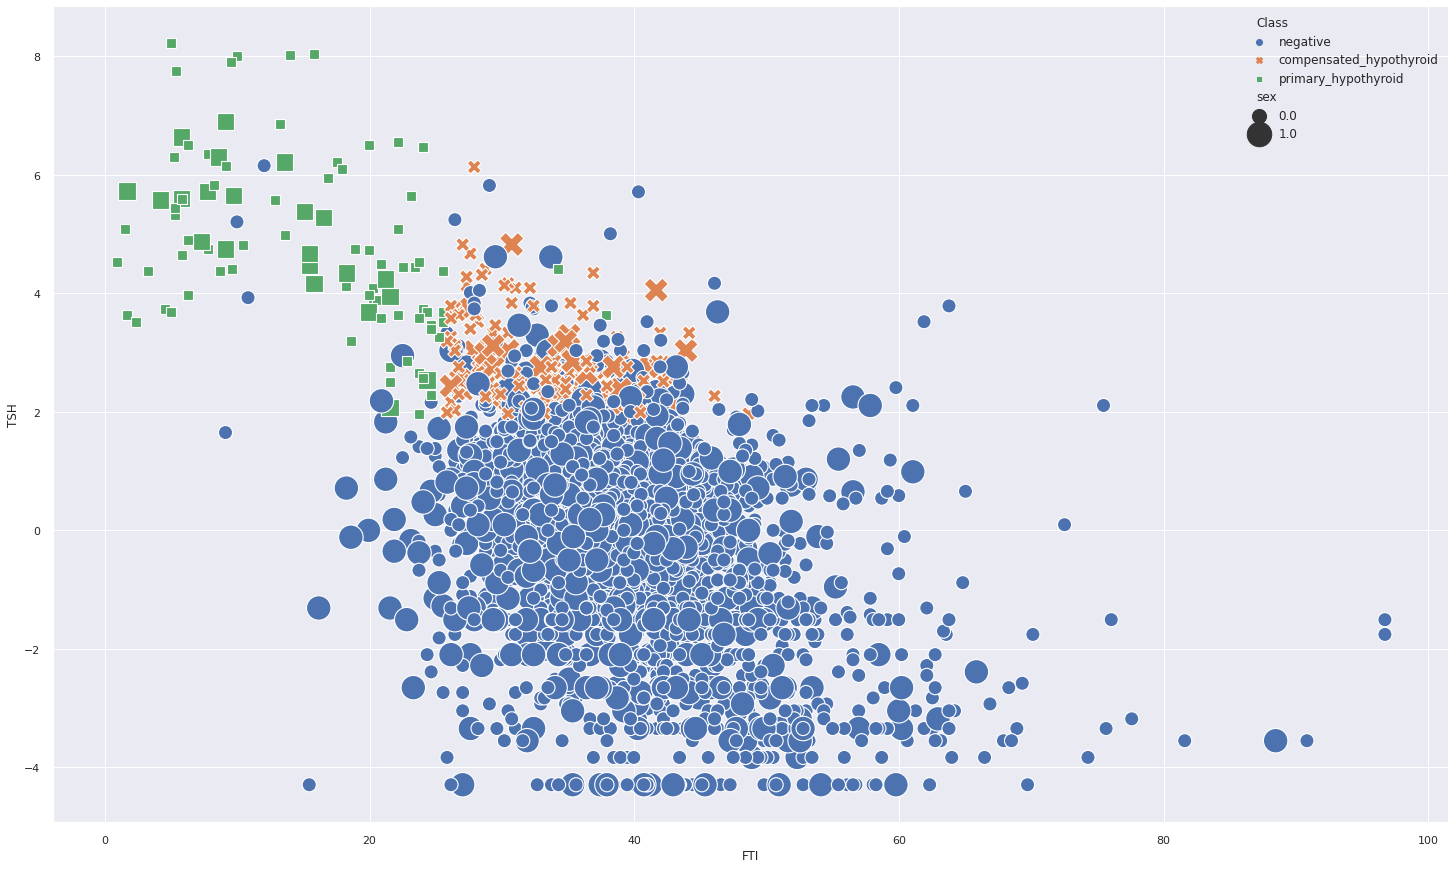

In [ ]:
# We can expect the model to confuse objects from the negative class with compensated.
# And compensated with primary
plt.figure(figsize=(25, 15))
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(
    x="FTI",
    y="TSH",
    hue="Class",
    style='Class',
    size='sex',
    sizes={0: 200, 1: 600},
    data=data
)
plt.show()

#### Correlation

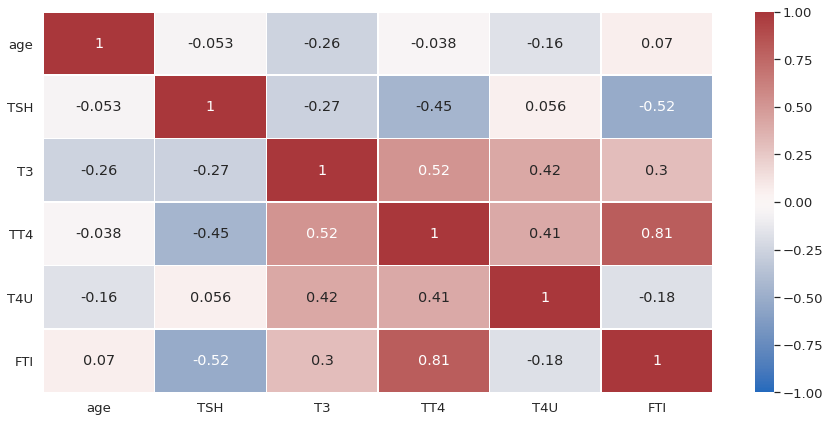

In [ ]:
# there is no multicollinearity
corr_0 = data.loc[:, numeric_columns].copy()
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_0.corr(method='pearson'), vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

# Models

## Data Preparation

In [ ]:
# Read dataset and replace all -? values to np.nan
data = pd.read_csv("./data.csv", sep=',', decimal='.', parse_dates=True, na_values="?")

In [ ]:
data.drop(columns=["TSH_measured", "T3_measured", "TT4_measured",
                   "T4U_measured", "FTI_measured", "TBG_measured",
                   "TBG", "referral_source", "age", "hypopituitary", 
                   "goitre", "lithium"], inplace=True)

data = data.loc[~(data["Class"]=="secondary_hypothyroid")]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Class']), data.loc[:, ['Class']], 
                                                    random_state=42, test_size=0.2, stratify=data.loc[:, ['Class']], 
                                                    shuffle=True) 

## Pipelines

In [ ]:
def my_pipline(cont_columns, ordinal_columns):
    # piplines with transformations
    pipeline_cont = Pipeline(steps=[
                                    ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_columns])),
                                    ('KNN', KNNImputer()),
                                    ('box_cox', PowerTransformer(standardize=True, method='box-cox')),              
                                    ])

    pipeline_cat = Pipeline(steps=[
                                   ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_columns])),
                                   ("Imputer", SimpleImputer(strategy='most_frequent')),
                                   ('enc', OrdinalEncoder())
                                ])
    
    # union piplines
    feature_union = FeatureUnion(transformer_list = [
                                                 ("pipeline_cont", pipeline_cont),
                                                 ("pipeline_cat", pipeline_cat)
                                                 ]
                                   )
    
    # model piplines
    log_reg = LogisticRegression(random_state=42, multi_class="multinomial") # 
    sm = SMOTE(random_state=42, k_neighbors=5)

    estimator_1 = imb_make_pipeline(steps = [
                                  ('feature_processing', feature_union),
                                  ('SMOTE', sm),
                                  ('model_fitting', log_reg) 
                                  ]
                                 )

    estimator_2 = imb_make_pipeline(steps = [
                                    ('feature_processing', feature_union),
                                    ("pca", PCA(n_components=0.95)),
                                    ('SMOTE', sm),
                                    ('model_fitting', log_reg) 
                                    ]
                                    )
    
    return estimator_1, estimator_2, feature_union


In [ ]:
cont_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']

ordinal_columns_full = ['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'tumor',
       'psych']

ordinal_columns_short = ['sex', 'on_thyroxine', 'sick', 'pregnant',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid',
       'psych']

In [ ]:
estimator_1_full, estimator_2_full, feature_union_full = my_pipline(cont_columns, ordinal_columns_full)
estimator_1_short, estimator_2_short, feature_union_short = my_pipline(cont_columns, ordinal_columns_short)

## UMAP

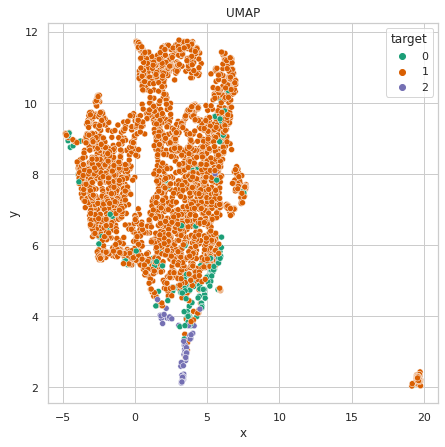

In [ ]:
train = feature_union_full.fit_transform(X=x_train.copy())

embedding = umap.UMAP(n_neighbors=20, min_dist=0.15).fit_transform(train)
plot_df = pd.DataFrame.from_records(data=embedding, columns=["x","y"])
plot_df["target"] = y_train

fig = plt.figure(figsize=(7,7))
plt.title(f"UMAP")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()

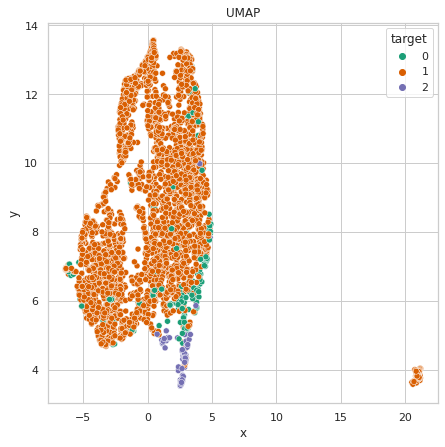

In [ ]:
train = feature_union_short.fit_transform(X=x_train.copy())

embedding = umap.UMAP(n_neighbors=20, min_dist=0.15).fit_transform(train)
plot_df = pd.DataFrame.from_records(data=embedding, columns=["x","y"])
plot_df["target"] = y_train

fig = plt.figure(figsize=(7,7))
plt.title(f"UMAP")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()

Classes are visually separable

## Model fitting

In [ ]:
# bad idea to use accuracy here
param_grid = {
    'model_fitting__penalty': ["l1", "l2"],
    'model_fitting__C': [0.01, 0.1, 1, 10], 
    'model_fitting__solver': ['liblinear','lbfgs','saga']
}

# search for var_1
estimator_1_full_grid = GridSearchCV(estimator_1_full, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   cv = 5, 
                   return_train_score=True 
                  )

# search for var_2
estimator_2_full_grid = GridSearchCV(estimator_2_full, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   cv = 5, 
                   return_train_score=True 
                  )

# search for var_3
estimator_1_short_grid = GridSearchCV(estimator_1_short, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   cv = 5, 
                   return_train_score=True 
                  )

# search for var_4
estimator_2_short_grid = GridSearchCV(estimator_2_short, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   cv = 5, 
                   return_train_score=True 
                  )

In [ ]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

Classes are unbalanced, so we need to use metrices like preccision and recall

### FULL model without PCA

In [ ]:
estimator_1_full_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('pipeline_cont',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4950>)),
                                                                                        ('KNN',
                                                                                         KNNImputer()),
                                                                                        ('box_cox',
                                                                                         PowerTransformer(method='box-cox'))])),
                                                                       ('pipeline_cat',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionT...
                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                        ('enc',
                                                                                         OrdinalEncoder())]))])),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('model_fitting',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=42))]),
             param_grid={'model_fitting__C': [0.01, 0.1, 1, 10],
                         'model_fitting__penalty': ['l1', 'l2'],
                         'model_fitting__solver': ['liblinear', 'lbfgs',
                                                   'saga']},
             return_train_score=True, scoring='accuracy')

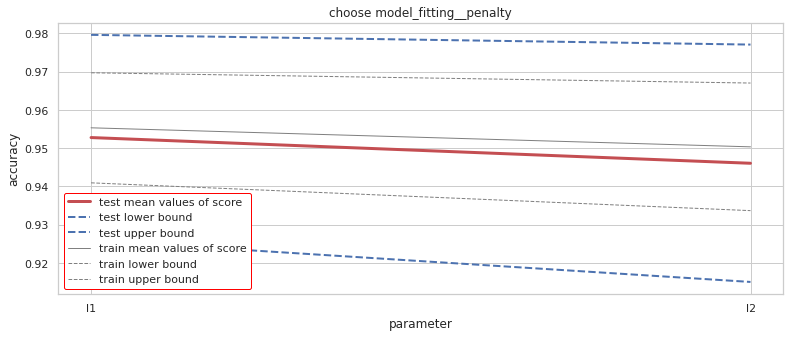

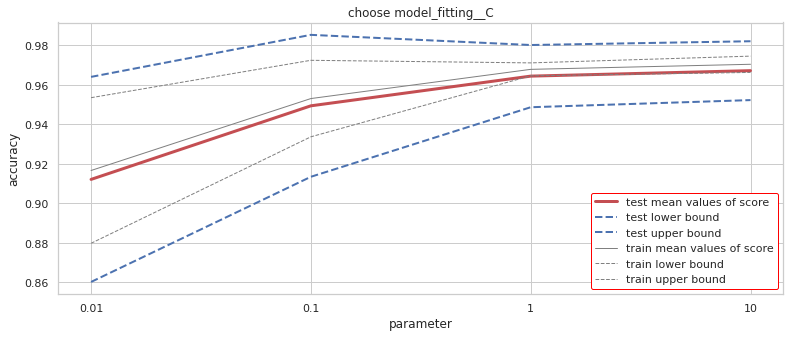

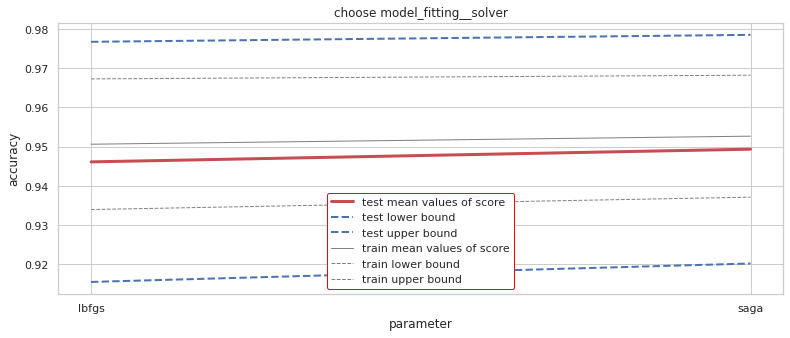

In [ ]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(estimator_1_full_grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
print(estimator_1_full_grid.best_estimator_.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('pipeline_cont',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4950>)),
                                                                 ('KNN',
                                                                  KNNImputer()),
                                                                 ('box_cox',
                                                                  PowerTransformer(method='box-cox'))])),
                                                ('pipeline_cat',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4e6

In [ ]:
predict_proba_1 = estimator_1_full_grid.best_estimator_.predict_proba(x_test)
predict_1 = estimator_1_full_grid.best_estimator_.predict(x_test)

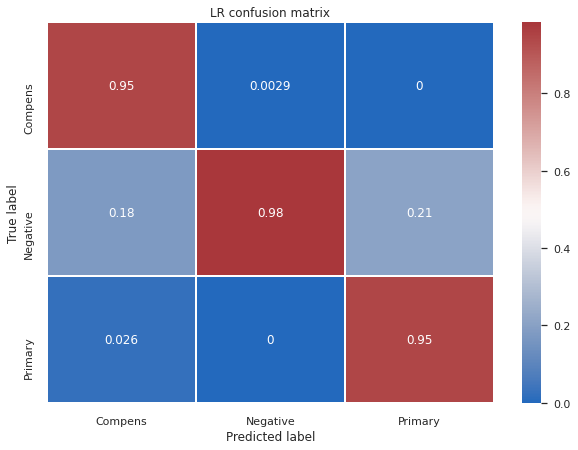

In [ ]:
# Получается, что мы путаем Негативный класс с Компенсаторным синдромом
# А компенсаторный синдром путаем с Первичным заболеванием
# Ничего странного в этом нет, компенсаторный синдром имеет общие черты, как с негативным классом, так и с первичным заболеванием
conf_matrix(y_test, predict_1, model='LR')

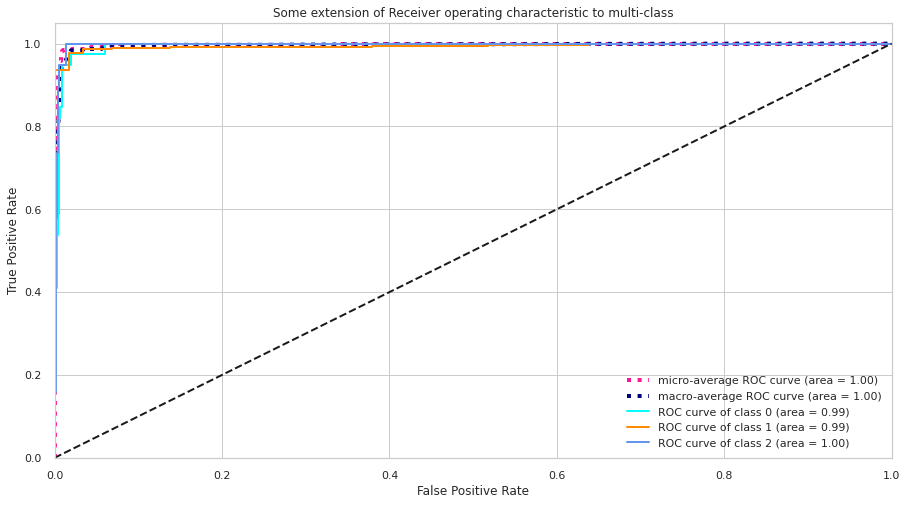

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=predict_proba_1, n_classes=3)

In [ ]:
prec_1_micro = precision_score(y_test, predict_1, average="micro")
recall_1_micro = recall_score(y_test, predict_1, average="micro")

prec_1_macro = precision_score(y_test, predict_1, average="macro")
recall_1_macro = recall_score(y_test, predict_1, average="macro")

print(f"precision_score micro: {prec_1_micro}, recall_score micro: {recall_1_micro}")
print(f"precision_score macro: {prec_1_macro}, recall_score macro: {recall_1_macro}")

f1_macro_1 = f1_score(y_test, predict_1, average='macro')
print(f"f1_score: {f1_macro_1}")

precision_score micro: 0.9814323607427056, recall_score micro: 0.9814323607427056
precision_score macro: 0.8791642774175527, recall_score macro: 0.9600939240231435
f1_score: 0.9165337686844485


### FULL model with PCA

In [ ]:
estimator_2_full_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('pipeline_cont',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4950>)),
                                                                                        ('KNN',
                                                                                         KNNImputer()),
                                                                                        ('box_cox',
                                                                                         PowerTransformer(method='box-cox'))])),
                                                                       ('pipeline_cat',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionT...
                                                                                         OrdinalEncoder())]))])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('model_fitting',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=42))]),
             param_grid={'model_fitting__C': [0.01, 0.1, 1, 10],
                         'model_fitting__penalty': ['l1', 'l2'],
                         'model_fitting__solver': ['liblinear', 'lbfgs',
                                                   'saga']},
             return_train_score=True, scoring='accuracy')

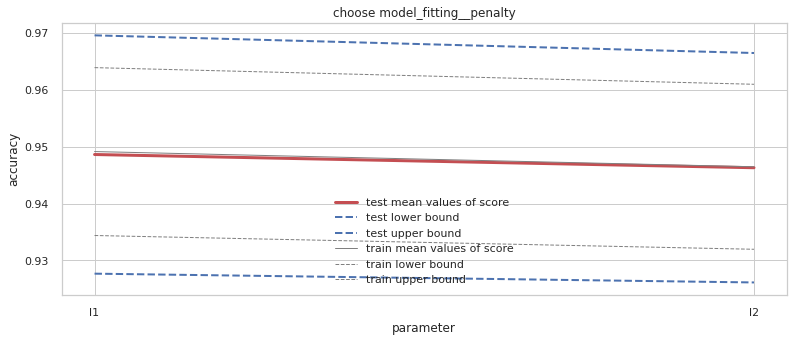

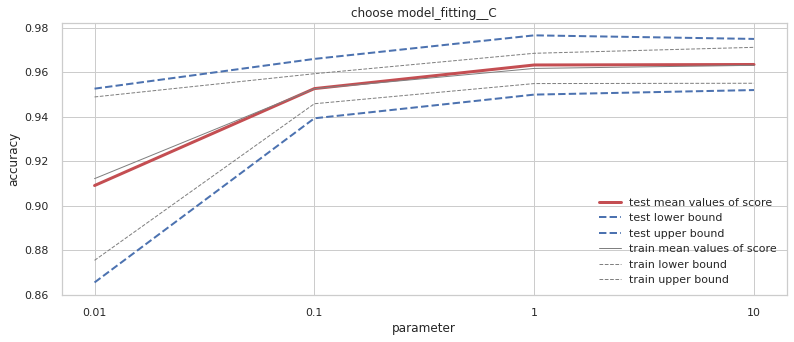

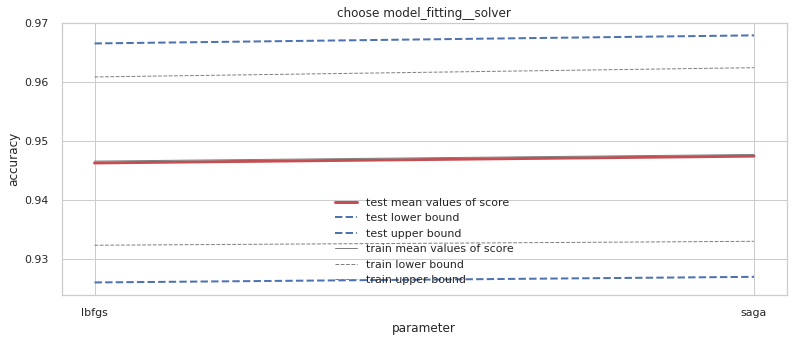

In [ ]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(estimator_2_full_grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
print(estimator_2_full_grid.best_estimator_.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('pipeline_cont',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4950>)),
                                                                 ('KNN',
                                                                  KNNImputer()),
                                                                 ('box_cox',
                                                                  PowerTransformer(method='box-cox'))])),
                                                ('pipeline_cat',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4e6

In [ ]:
predict_proba_2 = estimator_2_full_grid.best_estimator_.predict_proba(x_test)
predict_2 = estimator_2_full_grid.best_estimator_.predict(x_test)

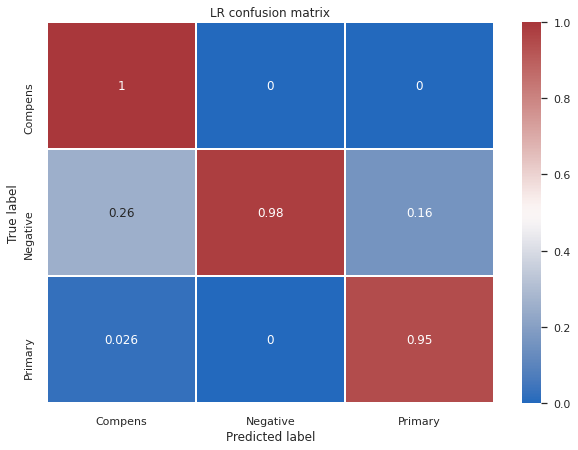

In [ ]:
conf_matrix(y_test, predict_2, model='LR')

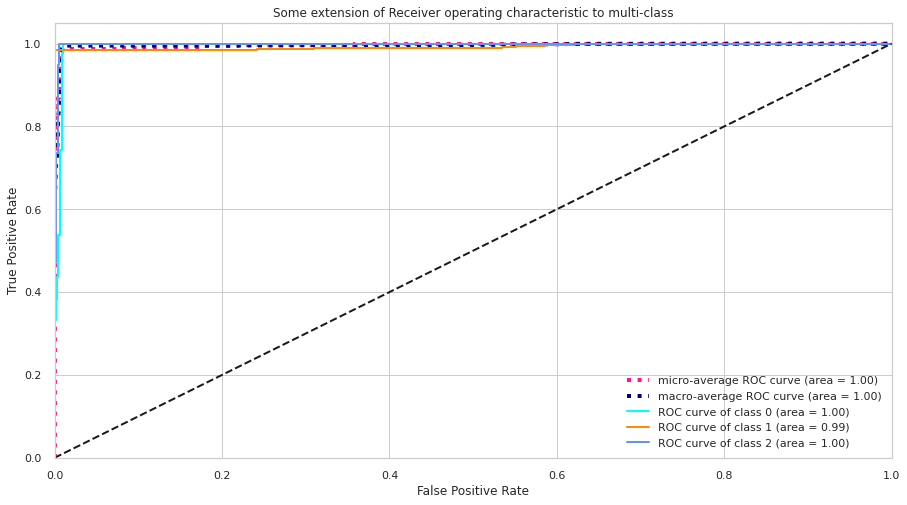

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=predict_proba_2, n_classes=3)

In [ ]:
prec_2_micro = precision_score(y_test, predict_2, average="micro")
recall_2_micro = recall_score(y_test, predict_2, average="micro")

prec_2_macro = precision_score(y_test, predict_2, average="macro")
recall_2_macro = recall_score(y_test, predict_2, average="macro")

print(f"precision_score micro: {prec_2_micro}, recall_score micro: {recall_2_micro}")
print(f"precision_score macro: {prec_2_macro}, recall_score macro: {recall_2_macro}")

f1_macro_2 = f1_score(y_test, predict_2, average='macro')
print(f"f1_score: {f1_macro_2}")

precision_score micro: 0.9814323607427056, recall_score micro: 0.9814323607427056
precision_score macro: 0.879047619047619, recall_score macro: 0.9762300867110304
f1_score: 0.9223257910932582


### SHORT model without PCA

In [ ]:
estimator_1_short_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('pipeline_cont',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4dd0>)),
                                                                                        ('KNN',
                                                                                         KNNImputer()),
                                                                                        ('box_cox',
                                                                                         PowerTransformer(method='box-cox'))])),
                                                                       ('pipeline_cat',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionT...
                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                        ('enc',
                                                                                         OrdinalEncoder())]))])),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('model_fitting',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=42))]),
             param_grid={'model_fitting__C': [0.01, 0.1, 1, 10],
                         'model_fitting__penalty': ['l1', 'l2'],
                         'model_fitting__solver': ['liblinear', 'lbfgs',
                                                   'saga']},
             return_train_score=True, scoring='accuracy')

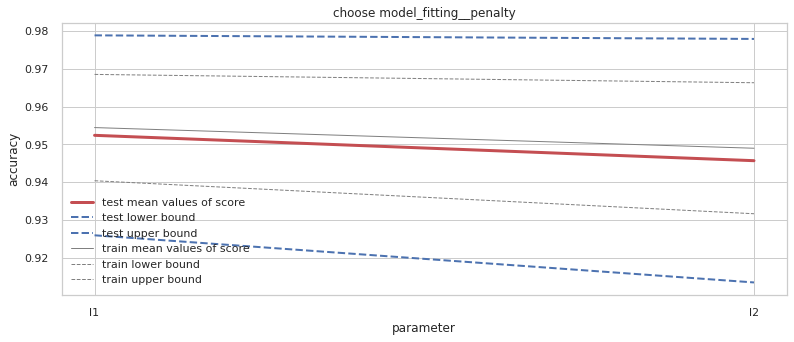

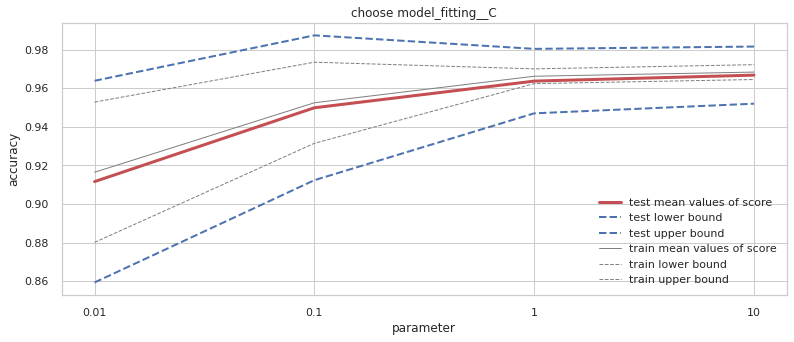

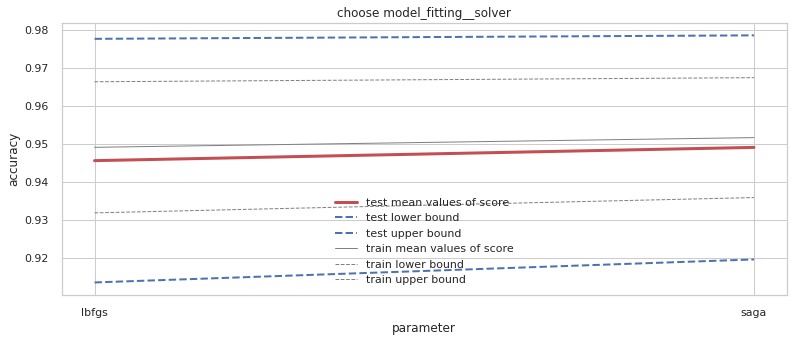

In [ ]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(estimator_1_short_grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
print(estimator_1_short_grid.best_estimator_.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('pipeline_cont',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4dd0>)),
                                                                 ('KNN',
                                                                  KNNImputer()),
                                                                 ('box_cox',
                                                                  PowerTransformer(method='box-cox'))])),
                                                ('pipeline_cat',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4cb

In [ ]:
predict_proba_3 = estimator_1_short_grid.best_estimator_.predict_proba(x_test)
predict_3 = estimator_1_short_grid.best_estimator_.predict(x_test)

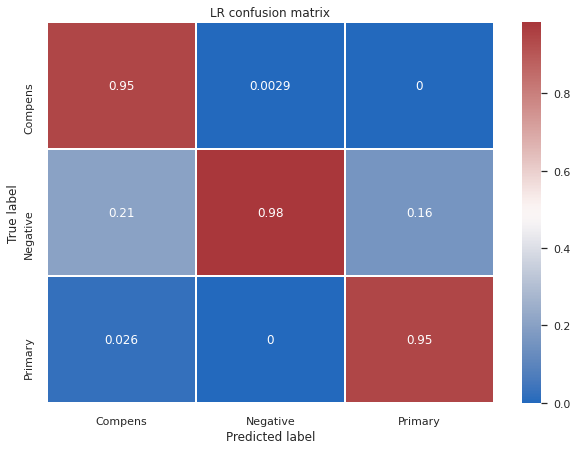

In [ ]:
# Получается, что мы путаем Негативный класс с Компенсаторным синдромом
# А компенсаторный синдром путаем с Первичным заболеванием
# Ничего странного в этом нет, компенсаторный синдром имеет общие черты, как с негативным классом, так и с первичным заболеванием
conf_matrix(y_test, predict_3, model='LR')

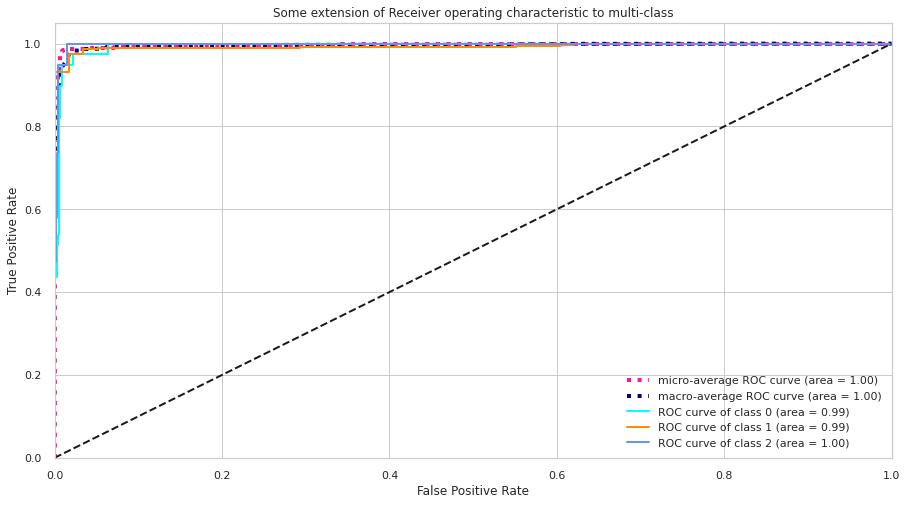

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=predict_proba_3, n_classes=3)

In [ ]:
prec_3_micro = precision_score(y_test, predict_3, average="micro")
recall_3_micro = recall_score(y_test, predict_3, average="micro")

prec_3_macro = precision_score(y_test, predict_3, average="macro")
recall_3_macro = recall_score(y_test, predict_3, average="macro")

print(f"precision_score micro: {prec_3_micro}, recall_score micro: {recall_3_micro}")
print(f"precision_score macro: {prec_3_macro}, recall_score macro: {recall_3_macro}")

f1_macro_3 = f1_score(y_test, predict_3, average='macro')
print(f"f1_score: {f1_macro_3}")

precision_score micro: 0.9814323607427056, recall_score micro: 0.9814323607427056
precision_score macro: 0.886193158359477, recall_score macro: 0.9600939240231435
f1_score: 0.9203961266357591


### SHORT model with PCA

In [ ]:
estimator_2_short_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('pipeline_cont',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4dd0>)),
                                                                                        ('KNN',
                                                                                         KNNImputer()),
                                                                                        ('box_cox',
                                                                                         PowerTransformer(method='box-cox'))])),
                                                                       ('pipeline_cat',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionT...
                                                                                         OrdinalEncoder())]))])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('model_fitting',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=42))]),
             param_grid={'model_fitting__C': [0.01, 0.1, 1, 10],
                         'model_fitting__penalty': ['l1', 'l2'],
                         'model_fitting__solver': ['liblinear', 'lbfgs',
                                                   'saga']},
             return_train_score=True, scoring='accuracy')

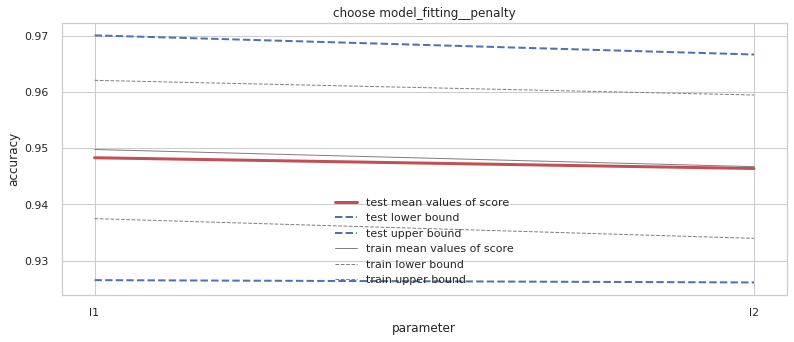

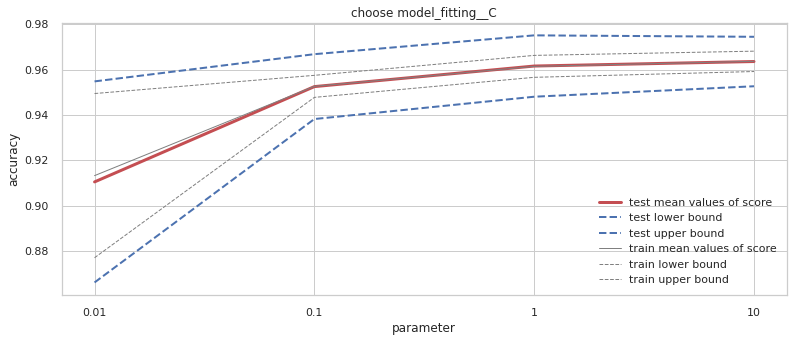

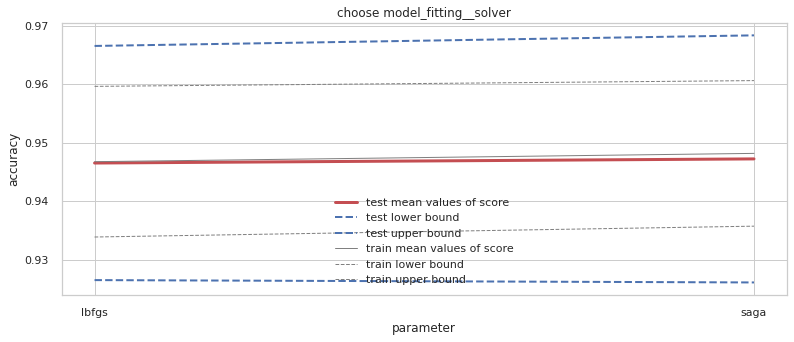

In [ ]:
# Рисуем кривые валидации 
rs_df = pd.DataFrame(estimator_2_short_grid.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
print(estimator_2_short_grid.best_estimator_.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('pipeline_cont',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4dd0>)),
                                                                 ('KNN',
                                                                  KNNImputer()),
                                                                 ('box_cox',
                                                                  PowerTransformer(method='box-cox'))])),
                                                ('pipeline_cat',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function my_pipline.<locals>.<lambda> at 0x7ff27d1a4cb

In [ ]:
predict_proba_4 = estimator_2_short_grid.best_estimator_.predict_proba(x_test)
predict_4 = estimator_2_short_grid.best_estimator_.predict(x_test)

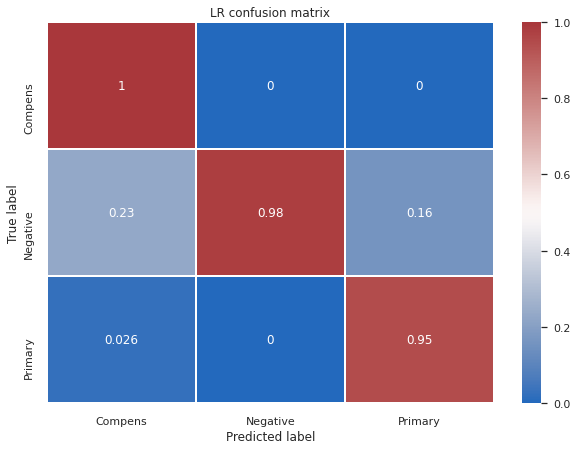

In [ ]:
conf_matrix(y_test, predict_4, model='LR')

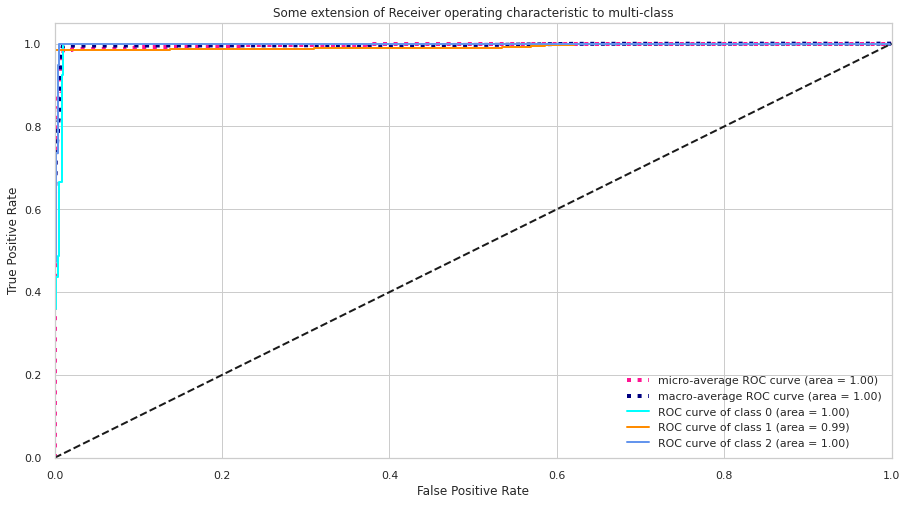

In [ ]:
roc_graph(y_test_bin=y_test_bin, predict_proba=predict_proba_4, n_classes=3)

In [ ]:
prec_4_micro = precision_score(y_test, predict_4, average="micro")
recall_4_micro = recall_score(y_test, predict_4, average="micro")

prec_4_macro = precision_score(y_test, predict_4, average="macro")
recall_4_macro = recall_score(y_test, predict_4, average="macro")

print(f"precision_score micro: {prec_4_micro}, recall_score micro: {recall_4_micro}")
print(f"precision_score macro: {prec_4_macro}, recall_score macro: {recall_4_macro}")

f1_macro_4 = f1_score(y_test, predict_4, average='macro')
print(f"f1_score: {f1_macro_4}")

precision_score micro: 0.9827586206896551, recall_score micro: 0.9827586206896551
precision_score macro: 0.8843537414965986, recall_score macro: 0.9767090139140956
f1_score: 0.9258893280632411


### Results

In [ ]:
print("Metrics:")
print("Precisions:")
print(f"model_1: {prec_1_macro*100:.5}, model_2: {prec_2_macro*100:.5}, model_3: {prec_3_macro*100:.5}, model_4: {prec_4_macro*100:.5}")
print("Recalls:")
print(f"model_1: {recall_1_macro*100:.5}, model_2: {recall_2_macro*100:.5}, model_3: {recall_3_macro*100:.5}, model_4: {recall_4_macro*100:.5}")

Metrics:
Precisions:
model_1: 87.916, model_2: 87.905, model_3: 88.619, model_4: 88.435
Recalls:
model_1: 96.009, model_2: 97.623, model_3: 96.009, model_4: 97.671


A model trained on a short subset shows the best quality  
Model with PCA has higher recall
Model with PCA has higher precision

I think that we should prefer the model with higher recall
This way we minimize the number of missed patients


### KNN and RF

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train = feature_union_short.fit_transform(X=x_train.copy())
test = feature_union_short.transform(X=x_test.copy())

knn = KNeighborsClassifier()
knn.fit(X=train, y=y_train.Class)
predict_knn = knn.predict(test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X=train, y=y_train.Class)
predict_rf = rf.predict(test)

In [ ]:
# rf results
# RF from the box better than tunned LR
prec_rf_micro = precision_score(y_test, predict_rf, average="micro")
recall_rf_micro = recall_score(y_test, predict_rf, average="micro")

prec_rf_macro = precision_score(y_test, predict_rf, average="macro")
recall_rf_macro = recall_score(y_test, predict_rf, average="macro")

f1_macro_rf = f1_score(y_test, predict_rf, average='macro')

print(f"precision_score micro: {prec_rf_micro}, recall_score micro: {recall_rf_micro}")
print(f"precision_score macro: {prec_rf_macro}, recall_score macro: {recall_rf_macro}")
print(f"f1_score: {f1_macro_rf}")

precision_score micro: 0.9893899204244032, recall_score micro: 0.9893899204244032
precision_score macro: 0.9347702519139146, recall_score macro: 0.9800324196875921
f1_score: 0.9564121037463976


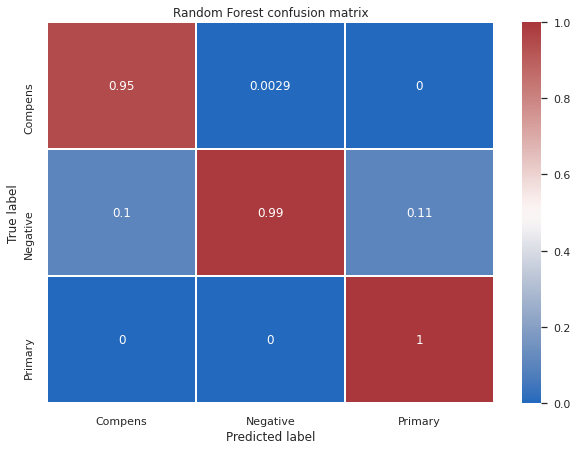

In [ ]:
conf_matrix(y_test, predict_rf, model="Random Forest")

In [ ]:
# knn results
# Not good enough
prec_knn_micro = precision_score(y_test, predict_knn, average="micro")
recall_knn_micro = recall_score(y_test, predict_knn, average="micro")

prec_knn_macro = precision_score(y_test, predict_knn, average="macro")
recall_knn_macro = recall_score(y_test, predict_knn, average="macro")

f1_macro_knn = f1_score(y_test, predict_knn, average='macro')

print(f"precision_score micro: {prec_knn_micro}, recall_score micro: {recall_knn_micro}")
print(f"precision_score macro: {prec_knn_macro}, recall_score macro: {recall_knn_macro}")
print(f"f1_score: {f1_macro_knn}")

precision_score micro: 0.9588859416445623, recall_score micro: 0.9588859416445623
precision_score macro: 0.8608403361344538, recall_score macro: 0.7223308049079374
f1_score 0.7787798984842164


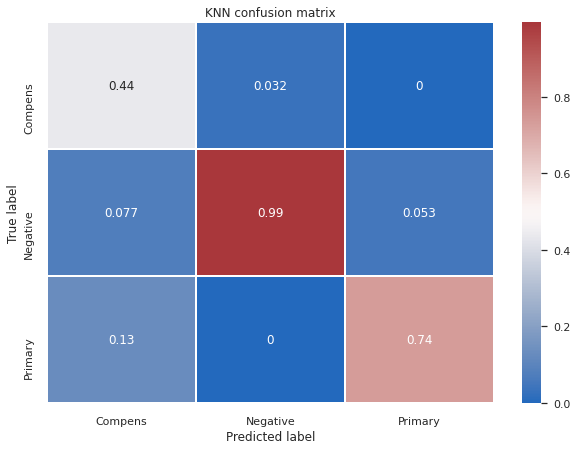

In [ ]:
conf_matrix(y_test, predict_knn, model="KNN")